## Traction Analytics Prediction

### Methodology

1. Data Preparation
- Concat daily downloads of weekly article activities from NewsWhip
- Calculate percentage and absolute change of each article across days

2. Define labels
- Set gradient threshold and abs interaction value threshold
- For each article, build a linear regression model for the facebook interactions over time and obtain the gradient
- If the gradient > threshold | abs interaction count > threshold -> trending
- Else if the gradient < -threshold -> untrending
- Else -> neutral

3. EDA of labels
- Readjust threholds if necessary
- Under or oversampling if necessary

4. Deep learning pipeline (SetFit for Few Shot)
- Tokenise
- Train-test split : 80/20
- Model evaluation using precision, recall and F1
- Model comparison

### Data Preperation

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast 

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

In [45]:
# Read and perform basic data processing

df = pd.read_csv('data/combined_data_merged.csv')
df = df[['published', 'headline', 'summary', 'link', 'domain','facebook_interactions', 'date_extracted', 'suggested_labels']]
df['published'] = pd.to_datetime(df['published'])
df['date_extracted'] = pd.to_datetime(df['date_extracted'])

# convert suggested_labels to list
df['suggested_labels'] = df['suggested_labels'].apply(lambda x: ast.literal_eval(x))
df['article_theme'] = df['suggested_labels'].apply(lambda x: x[0].split(' > ')[0])
df['article_index'] = df['suggested_labels'].apply(lambda x: x[0].split(' > ')[1])

df = df.drop(columns=['suggested_labels'])
df = df.sort_values(by=['headline', 'published', 'date_extracted'], ascending=[False, True, True]).reset_index(drop=True)

df

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,general,others
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05,general,others
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07,general,others
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08,general,others
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09,general,others
...,...,...,...,...,...,...,...,...,...
4885,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,784,2023-05-04,general,others
4886,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,868,2023-05-05,general,others
4887,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1038,2023-05-07,general,others
4888,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1070,2023-05-08,general,others


In [46]:
df["article_index"].value_counts()

others                      2345
sea games                    850
food prices                  298
ndp                          191
border reopening             145
football                     130
4d/toto                      124
weather                       93
deaths                        56
scams                         52
layoffs                       39
parliament                    39
mbs                           36
winter olympics               34
world cup                     29
teachers                      28
service disruptions           27
hari raya                     27
chicken supply                24
safe management measures      23
nsf                           23
coe prices                    23
resale prices                 22
crypto                        21
msia politics                 20
local athletes                19
ndr                           17
taxi fares                    17
dbs                           15
support measures              15
healthcare

In [47]:
# Create a dataframe with unique articles only

df_unique = df.drop_duplicates(subset=['headline', 'published'], keep='first').reset_index(drop=True)

# creature a feature for the number of hours since the article of the same article_index was published

df_unique['hours_since_published'] = df_unique.sort_values(by=['published']).groupby(['article_index'])['published'].diff().dt.total_seconds().div(3600)
df_unique['hours_since_published'] = df_unique['hours_since_published'].fillna(0)

df_unique = df_unique.sort_values(by=['article_index', 'published'], ascending=[True, True]).reset_index(drop=True)

df_unique

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,hours_since_published
0,2023-05-02 00:56:12,Celebrity beauty files: Naomi Yeo on becoming ...,â€œIâ€™m a bit of a late bloomer coming into f...,https://www.facebook.com/93889432933_101596052...,cnalifestyle.channelnewsasia.com,321,2023-05-04,general,4d/toto,0.000000
1,2023-05-02 06:30:13,Feel compelled to chop it all off? This may be...,"The ""Ur hair holds memories"" TikTok trend is s...",https://www.facebook.com/345185573000_61926142...,sg.news.yahoo.com,310,2023-05-04,general,4d/toto,5.566944
2,2023-05-03 09:20:01,Blackpink's Jisoo breaks bandmate Lisa's Spoti...,Flower took just 32 days to hit 100 million st...,https://www.facebook.com/129011692114_10159186...,straitstimes.com,1025,2023-05-04,general,4d/toto,26.830000
3,2023-05-03 11:30:45,'Run slow to run fast': Woman shares tips to k...,For those who want to start running but are no...,https://www.facebook.com/121790674546188_63771...,asiaone.com,746,2023-05-04,general,4d/toto,2.178889
4,2023-05-04 05:52:42,"Sâ€™pore Woman Shares Tips For Runners, Encour...",She says that building stamina and getting com...,https://www.facebook.com/292279440975148_55702...,mustsharenews.com,386,2023-05-07,general,4d/toto,18.365833
...,...,...,...,...,...,...,...,...,...,...
1329,2023-05-15 20:41:08,Ronaldo coming to S'pore again in June 2023,Ronaldo is coming to Singapore again.,https://www.facebook.com/592308557475467_66311...,mothership.sg,480,2023-05-17,sports,world cup,103.182778
1330,2023-05-16 03:56:42,Cristiano Ronaldo to visit Singapore in June,"""Looking forward to see all of you again next ...",https://www.facebook.com/93889432933_101596341...,channelnewsasia.com,998,2023-05-17,sports,world cup,7.259444
1331,2023-05-20 06:59:04,Fan goes overboard groping Jackson Wang at Bra...,Some fans called it out as an example of haras...,https://www.facebook.com/592308557475467_66463...,mothership.sg,364,2023-05-22,sports,world cup,99.039444
1332,2023-05-20 09:00:14,Singer Jackson Wang groped by fan onstage duri...,"The fan hugged Wang and, at one point, moved h...",https://www.facebook.com/129011692114_10159217...,straitstimes.com,2749,2023-05-21,sports,world cup,2.019444


### Domain Analysis

In [48]:
df_unique['domain'].value_counts()

straitstimes.com                    285
mothership.sg                       276
asiaone.com                         169
channelnewsasia.com                 158
mustsharenews.com                    86
sg.news.yahoo.com                    80
sg.style.yahoo.com                   63
todayonline.com                      48
stomp.straitstimes.com               42
cnalifestyle.channelnewsasia.com     39
tnp.straitstimes.com                 32
sg.finance.yahoo.com                 12
babelfish.mothership.sg              11
coconuts.co                           6
goodyfeed.com                         6
au.news.yahoo.com                     4
businesstimes.com.sg                  4
uk.news.yahoo.com                     3
ricemedia.co                          2
cnaluxury.channelnewsasia.com         2
au.lifestyle.yahoo.com                2
theonlinecitizen.com                  2
malaysia.news.yahoo.com               1
public.flourish.studio                1
Name: domain, dtype: int64

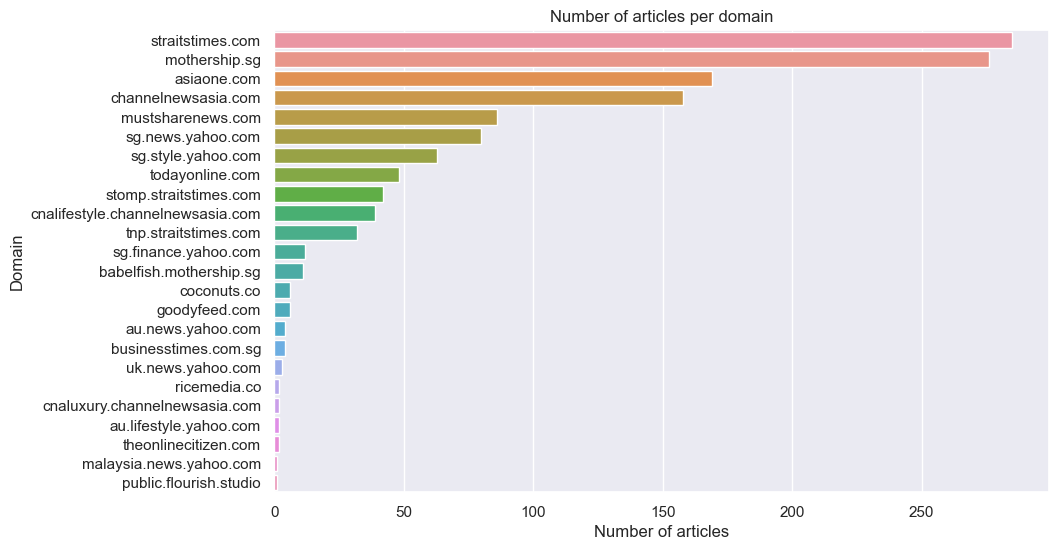

In [49]:
#plot the number of articles per domain

plt.figure(figsize=(10, 6))
sns.countplot(y='domain', data=df_unique, order=df_unique['domain'].value_counts().index)
plt.title('Number of articles per domain')
plt.xlabel('Number of articles')
plt.ylabel('Domain')
plt.show()

In [50]:
domain_map = {
    'asiaone': ['asiaone.com'],
    'businesstimes': ['businesstimes.com.sg'],
    'channelnewsasia': ['channelnewsasia.com', 'cnalifestyle.channelnewsasia.com', 'cnaluxury.channelnewsasia.com'],
    'goodyfeed': ['goodyfeed.com'],
    'mothership': ['babelfish.mothership.sg', 'mothership.sg', ],
    'mustsharenews': ['mustsharenews.com'],
    'ricemedia': ['ricemedia.co'],
    'straitstimes': ['straitstimes.com'],
    'stomp': ['stomp.straitstimes.com'],
    'thenewpaper': ['tnp.straitstimes.com'],
    'theonlinecitizen': ['theonlinecitizen.com'],
    'today': ['todayonline.com'],
    'yahoosingapore': ['sg.finance.yahoo.com', 'sg.news.yahoo.com', 'sg.style.yahoo.com'],
    # 'others': ['au.lifestyle.yahoo.com', 'au.news.yahoo.com','coconuts.co','malaysia.news.yahoo.com','public.flourish.studio', 'uk.news.yahoo.com']
}

reverse_domain_map = {}
for key, value in domain_map.items():
    for v in value:
        reverse_domain_map[v] = key
        
reverse_domain_map

{'asiaone.com': 'asiaone',
 'businesstimes.com.sg': 'businesstimes',
 'channelnewsasia.com': 'channelnewsasia',
 'cnalifestyle.channelnewsasia.com': 'channelnewsasia',
 'cnaluxury.channelnewsasia.com': 'channelnewsasia',
 'goodyfeed.com': 'goodyfeed',
 'babelfish.mothership.sg': 'mothership',
 'mothership.sg': 'mothership',
 'mustsharenews.com': 'mustsharenews',
 'ricemedia.co': 'ricemedia',
 'straitstimes.com': 'straitstimes',
 'stomp.straitstimes.com': 'stomp',
 'tnp.straitstimes.com': 'thenewpaper',
 'theonlinecitizen.com': 'theonlinecitizen',
 'todayonline.com': 'today',
 'sg.finance.yahoo.com': 'yahoosingapore',
 'sg.news.yahoo.com': 'yahoosingapore',
 'sg.style.yahoo.com': 'yahoosingapore'}

In [51]:
domain_traffic = {
    'asiaone': [4990000,1290000],
    'businesstimes': [1630000, 622688],
    'channelnewsasia': [14760000, 2330000],
    'goodyfeed': [891376, 461731],
    'mothership': [6770000, 1660000],
    'mustsharenews': [2010000, 823526],
    'ricemedia': [148791, 86394],
    'straitstimes': [12310000, 2230000],
    'stomp': [1270000, 427113],
    'theindependent': [2370000, 683818],
    'thenewpaper': [707314, 350734],
    'theonlinecitizen': [657013, 233237],
    'today': [3660000, 1170000],
    'yahoosingapore': [5010000, 561434],

}

traffic_table = pd.DataFrame.from_dict(domain_traffic, orient='index', columns=['mean_monthly_visits', 'mean_monthly_unique_visitors']).reset_index().rename(columns={'index':'domain_group'})
traffic_table

,domain_group,mean_monthly_visits,mean_monthly_unique_visitors
0,asiaone,4990000,1290000
1,businesstimes,1630000,622688
2,channelnewsasia,14760000,2330000
3,goodyfeed,891376,461731
4,mothership,6770000,1660000
5,mustsharenews,2010000,823526
6,ricemedia,148791,86394
7,straitstimes,12310000,2230000
8,stomp,1270000,427113
9,theindependent,2370000,683818


Filtering data to include only articles present in mapping table

In [52]:
df = df[df["domain"].isin([i for a in list(domain_map.values()) for i in a])]
df

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,general,others
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05,general,others
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07,general,others
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08,general,others
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09,general,others
...,...,...,...,...,...,...,...,...,...
4885,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,784,2023-05-04,general,others
4886,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,868,2023-05-05,general,others
4887,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1038,2023-05-07,general,others
4888,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1070,2023-05-08,general,others


In [53]:
df_filtered = df_unique[df_unique["domain"].isin([i for a in list(domain_map.values()) for i in a])]
df_filtered

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,hours_since_published
0,2023-05-02 00:56:12,Celebrity beauty files: Naomi Yeo on becoming ...,â€œIâ€™m a bit of a late bloomer coming into f...,https://www.facebook.com/93889432933_101596052...,cnalifestyle.channelnewsasia.com,321,2023-05-04,general,4d/toto,0.000000
1,2023-05-02 06:30:13,Feel compelled to chop it all off? This may be...,"The ""Ur hair holds memories"" TikTok trend is s...",https://www.facebook.com/345185573000_61926142...,sg.news.yahoo.com,310,2023-05-04,general,4d/toto,5.566944
2,2023-05-03 09:20:01,Blackpink's Jisoo breaks bandmate Lisa's Spoti...,Flower took just 32 days to hit 100 million st...,https://www.facebook.com/129011692114_10159186...,straitstimes.com,1025,2023-05-04,general,4d/toto,26.830000
3,2023-05-03 11:30:45,'Run slow to run fast': Woman shares tips to k...,For those who want to start running but are no...,https://www.facebook.com/121790674546188_63771...,asiaone.com,746,2023-05-04,general,4d/toto,2.178889
4,2023-05-04 05:52:42,"Sâ€™pore Woman Shares Tips For Runners, Encour...",She says that building stamina and getting com...,https://www.facebook.com/292279440975148_55702...,mustsharenews.com,386,2023-05-07,general,4d/toto,18.365833
...,...,...,...,...,...,...,...,...,...,...
1329,2023-05-15 20:41:08,Ronaldo coming to S'pore again in June 2023,Ronaldo is coming to Singapore again.,https://www.facebook.com/592308557475467_66311...,mothership.sg,480,2023-05-17,sports,world cup,103.182778
1330,2023-05-16 03:56:42,Cristiano Ronaldo to visit Singapore in June,"""Looking forward to see all of you again next ...",https://www.facebook.com/93889432933_101596341...,channelnewsasia.com,998,2023-05-17,sports,world cup,7.259444
1331,2023-05-20 06:59:04,Fan goes overboard groping Jackson Wang at Bra...,Some fans called it out as an example of haras...,https://www.facebook.com/592308557475467_66463...,mothership.sg,364,2023-05-22,sports,world cup,99.039444
1332,2023-05-20 09:00:14,Singer Jackson Wang groped by fan onstage duri...,"The fan hugged Wang and, at one point, moved h...",https://www.facebook.com/129011692114_10159217...,straitstimes.com,2749,2023-05-21,sports,world cup,2.019444


In [54]:
# mapping domain to domain group

df_filtered['domain_group'] = df_filtered['domain'].map(reverse_domain_map)
df_filtered

C:\Users\edmun\AppData\Local\Temp\ipykernel_29952\2727172548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['domain_group'] = df_filtered['domain'].map(reverse_domain_map)


,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,hours_since_published,domain_group
0,2023-05-02 00:56:12,Celebrity beauty files: Naomi Yeo on becoming ...,â€œIâ€™m a bit of a late bloomer coming into f...,https://www.facebook.com/93889432933_101596052...,cnalifestyle.channelnewsasia.com,321,2023-05-04,general,4d/toto,0.000000,channelnewsasia
1,2023-05-02 06:30:13,Feel compelled to chop it all off? This may be...,"The ""Ur hair holds memories"" TikTok trend is s...",https://www.facebook.com/345185573000_61926142...,sg.news.yahoo.com,310,2023-05-04,general,4d/toto,5.566944,yahoosingapore
2,2023-05-03 09:20:01,Blackpink's Jisoo breaks bandmate Lisa's Spoti...,Flower took just 32 days to hit 100 million st...,https://www.facebook.com/129011692114_10159186...,straitstimes.com,1025,2023-05-04,general,4d/toto,26.830000,straitstimes
3,2023-05-03 11:30:45,'Run slow to run fast': Woman shares tips to k...,For those who want to start running but are no...,https://www.facebook.com/121790674546188_63771...,asiaone.com,746,2023-05-04,general,4d/toto,2.178889,asiaone
4,2023-05-04 05:52:42,"Sâ€™pore Woman Shares Tips For Runners, Encour...",She says that building stamina and getting com...,https://www.facebook.com/292279440975148_55702...,mustsharenews.com,386,2023-05-07,general,4d/toto,18.365833,mustsharenews
...,...,...,...,...,...,...,...,...,...,...,...
1329,2023-05-15 20:41:08,Ronaldo coming to S'pore again in June 2023,Ronaldo is coming to Singapore again.,https://www.facebook.com/592308557475467_66311...,mothership.sg,480,2023-05-17,sports,world cup,103.182778,mothership
1330,2023-05-16 03:56:42,Cristiano Ronaldo to visit Singapore in June,"""Looking forward to see all of you again next ...",https://www.facebook.com/93889432933_101596341...,channelnewsasia.com,998,2023-05-17,sports,world cup,7.259444,channelnewsasia
1331,2023-05-20 06:59:04,Fan goes overboard groping Jackson Wang at Bra...,Some fans called it out as an example of haras...,https://www.facebook.com/592308557475467_66463...,mothership.sg,364,2023-05-22,sports,world cup,99.039444,mothership
1332,2023-05-20 09:00:14,Singer Jackson Wang groped by fan onstage duri...,"The fan hugged Wang and, at one point, moved h...",https://www.facebook.com/129011692114_10159217...,straitstimes.com,2749,2023-05-21,sports,world cup,2.019444,straitstimes


In [55]:
# merge traffic table with df_filtered on domain and domain_group respectively

df_unique = df_filtered.merge(traffic_table, on='domain_group', how='left')
df_unique


,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,hours_since_published,domain_group,mean_monthly_visits,mean_monthly_unique_visitors
0,2023-05-02 00:56:12,Celebrity beauty files: Naomi Yeo on becoming ...,â€œIâ€™m a bit of a late bloomer coming into f...,https://www.facebook.com/93889432933_101596052...,cnalifestyle.channelnewsasia.com,321,2023-05-04,general,4d/toto,0.000000,channelnewsasia,14760000,2330000
1,2023-05-02 06:30:13,Feel compelled to chop it all off? This may be...,"The ""Ur hair holds memories"" TikTok trend is s...",https://www.facebook.com/345185573000_61926142...,sg.news.yahoo.com,310,2023-05-04,general,4d/toto,5.566944,yahoosingapore,5010000,561434
2,2023-05-03 09:20:01,Blackpink's Jisoo breaks bandmate Lisa's Spoti...,Flower took just 32 days to hit 100 million st...,https://www.facebook.com/129011692114_10159186...,straitstimes.com,1025,2023-05-04,general,4d/toto,26.830000,straitstimes,12310000,2230000
3,2023-05-03 11:30:45,'Run slow to run fast': Woman shares tips to k...,For those who want to start running but are no...,https://www.facebook.com/121790674546188_63771...,asiaone.com,746,2023-05-04,general,4d/toto,2.178889,asiaone,4990000,1290000
4,2023-05-04 05:52:42,"Sâ€™pore Woman Shares Tips For Runners, Encour...",She says that building stamina and getting com...,https://www.facebook.com/292279440975148_55702...,mustsharenews.com,386,2023-05-07,general,4d/toto,18.365833,mustsharenews,2010000,823526
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,2023-05-15 20:41:08,Ronaldo coming to S'pore again in June 2023,Ronaldo is coming to Singapore again.,https://www.facebook.com/592308557475467_66311...,mothership.sg,480,2023-05-17,sports,world cup,103.182778,mothership,6770000,1660000
1313,2023-05-16 03:56:42,Cristiano Ronaldo to visit Singapore in June,"""Looking forward to see all of you again next ...",https://www.facebook.com/93889432933_101596341...,channelnewsasia.com,998,2023-05-17,sports,world cup,7.259444,channelnewsasia,14760000,2330000
1314,2023-05-20 06:59:04,Fan goes overboard groping Jackson Wang at Bra...,Some fans called it out as an example of haras...,https://www.facebook.com/592308557475467_66463...,mothership.sg,364,2023-05-22,sports,world cup,99.039444,mothership,6770000,1660000
1315,2023-05-20 09:00:14,Singer Jackson Wang groped by fan onstage duri...,"The fan hugged Wang and, at one point, moved h...",https://www.facebook.com/129011692114_10159217...,straitstimes.com,2749,2023-05-21,sports,world cup,2.019444,straitstimes,12310000,2230000


In [56]:
# Calculate the absolute and percentage change in facebook interactions for each article

df['facebook_interactions_abs_change'] = df.groupby('link')['facebook_interactions'].diff().fillna(0)
# df['facebook_interactions_pct_change'] = df.groupby('link')['facebook_interactions'].pct_change().fillna(0)
df

C:\Users\edmun\AppData\Local\Temp\ipykernel_29952\1948972086.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['facebook_interactions_abs_change'] = df.groupby('link')['facebook_interactions'].diff().fillna(0)


,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,facebook_interactions_abs_change
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,general,others,0.0
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05,general,others,101.0
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07,general,others,182.0
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08,general,others,49.0
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09,general,others,25.0
...,...,...,...,...,...,...,...,...,...,...
4885,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,784,2023-05-04,general,others,0.0
4886,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,868,2023-05-05,general,others,84.0
4887,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1038,2023-05-07,general,others,170.0
4888,2023-05-02 09:00:51,#trending: 'Is Tom looking for Jerry'? Cat esc...,Just two days after videos of a rat scurrying ...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1070,2023-05-08,general,others,32.0


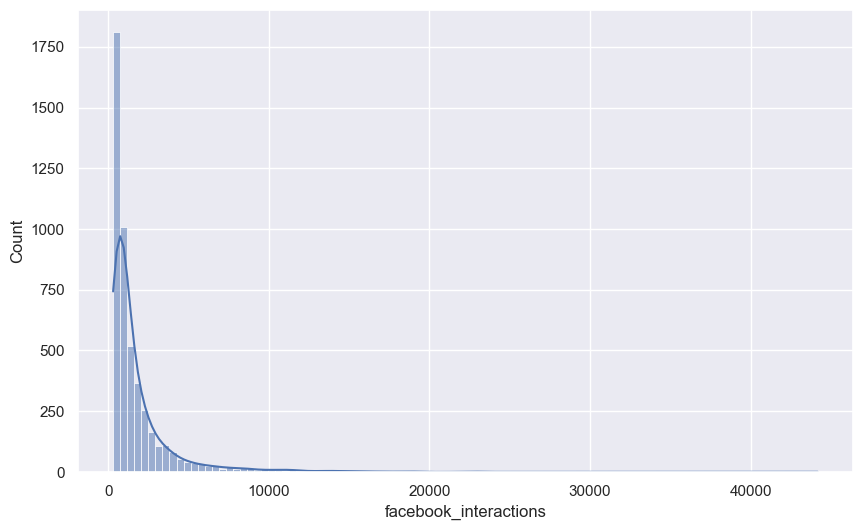

In [57]:
# plot histogram of facebook interactions pct change using seaborn

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='facebook_interactions', bins=100, kde=True)
plt.show()


#### Using gradient within each article

Benefits:
- Smoothens based on weekly activities

Issues:
- Reduces impact of spikes
- Gradient threshold not very explainable

In [58]:
from sklearn.linear_model import LinearRegression

# calculating mean and gradient of facebook interactions for each article

def cal_article_mean_and_gradient(val_array):
    val_array = np.asarray(val_array)
    mean = np.mean(val_array)
    val_array = np.nan_to_num(val_array)

    model = LinearRegression()
    model.fit(np.arange(len(val_array)).reshape(-1, 1), val_array)
    gradient = model.coef_[0]

    return mean, gradient


In [59]:
# Create a dataframe with unique articles and their corresponding labels

df_labels = df.groupby('link')['facebook_interactions'].agg(cal_article_mean_and_gradient).reset_index()

# Merge the unique articles dataframe with the labels dataframe

df_labelled = df_unique.merge(df_labels, on='link', how='left')
df_labelled = df_labelled.rename(columns={'facebook_interactions_x': 'facebook_interactions', 'facebook_interactions_y': 'mean_and_gradient'})
df_labelled['mean'] = df_labelled['mean_and_gradient'].apply(lambda x: x[0])
df_labelled['gradient'] = df_labelled['mean_and_gradient'].apply(lambda x: x[1])
df_labelled.drop(columns=['mean_and_gradient'], inplace=True)
df_labelled.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,hours_since_published,domain_group,mean_monthly_visits,mean_monthly_unique_visitors,mean,gradient
0,2023-05-02 00:56:12,Celebrity beauty files: Naomi Yeo on becoming ...,â€œIâ€™m a bit of a late bloomer coming into f...,https://www.facebook.com/93889432933_101596052...,cnalifestyle.channelnewsasia.com,321,2023-05-04,general,4d/toto,0.000000,channelnewsasia,14760000,2330000,336.500000,6.4
1,2023-05-02 06:30:13,Feel compelled to chop it all off? This may be...,"The ""Ur hair holds memories"" TikTok trend is s...",https://www.facebook.com/345185573000_61926142...,sg.news.yahoo.com,310,2023-05-04,general,4d/toto,5.566944,yahoosingapore,5010000,561434,404.400000,44.9
2,2023-05-03 09:20:01,Blackpink's Jisoo breaks bandmate Lisa's Spoti...,Flower took just 32 days to hit 100 million st...,https://www.facebook.com/129011692114_10159186...,straitstimes.com,1025,2023-05-04,general,4d/toto,26.830000,straitstimes,12310000,2230000,9933.400000,4089.5
3,2023-05-03 11:30:45,'Run slow to run fast': Woman shares tips to k...,For those who want to start running but are no...,https://www.facebook.com/121790674546188_63771...,asiaone.com,746,2023-05-04,general,4d/toto,2.178889,asiaone,4990000,1290000,4380.200000,1406.2
4,2023-05-04 05:52:42,"Sâ€™pore Woman Shares Tips For Runners, Encour...",She says that building stamina and getting com...,https://www.facebook.com/292279440975148_55702...,mustsharenews.com,386,2023-05-07,general,4d/toto,18.365833,mustsharenews,2010000,823526,392.333333,9.5


In [60]:
# Convert negative gradient to 0

df_labelled['gradient'] = df_labelled['gradient'].apply(lambda x: 0 if x < 0 else x)

In [61]:
# normalising the mean and gradient values on a gaussian distribution

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer

df_labelled['mean_s_scaled'] = StandardScaler().fit_transform(df_labelled[['mean']])
df_labelled['gradient_s_scaled'] = StandardScaler().fit_transform(df_labelled[['gradient']])

df_labelled['mean_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['mean']])
df_labelled['gradient_mm_scaled'] = MinMaxScaler().fit_transform(df_labelled[['gradient']])

df_labelled['mean_r_scaled'] = RobustScaler().fit_transform(df_labelled[['mean']])
df_labelled['gradient_r_scaled'] = RobustScaler().fit_transform(df_labelled[['gradient']])

df_labelled['mean_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['mean']])
df_labelled['gradient_pt_scaled'] = PowerTransformer().fit_transform(df_labelled[['gradient']])

df_labelled['mean_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['mean']])
df_labelled['gradient_qt_scaled'] = QuantileTransformer().fit_transform(df_labelled[['gradient']])

df_labelled['mean_log'] = np.log(df_labelled['mean'])
df_labelled['gradient_log'] = np.log(df_labelled['gradient'])



e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


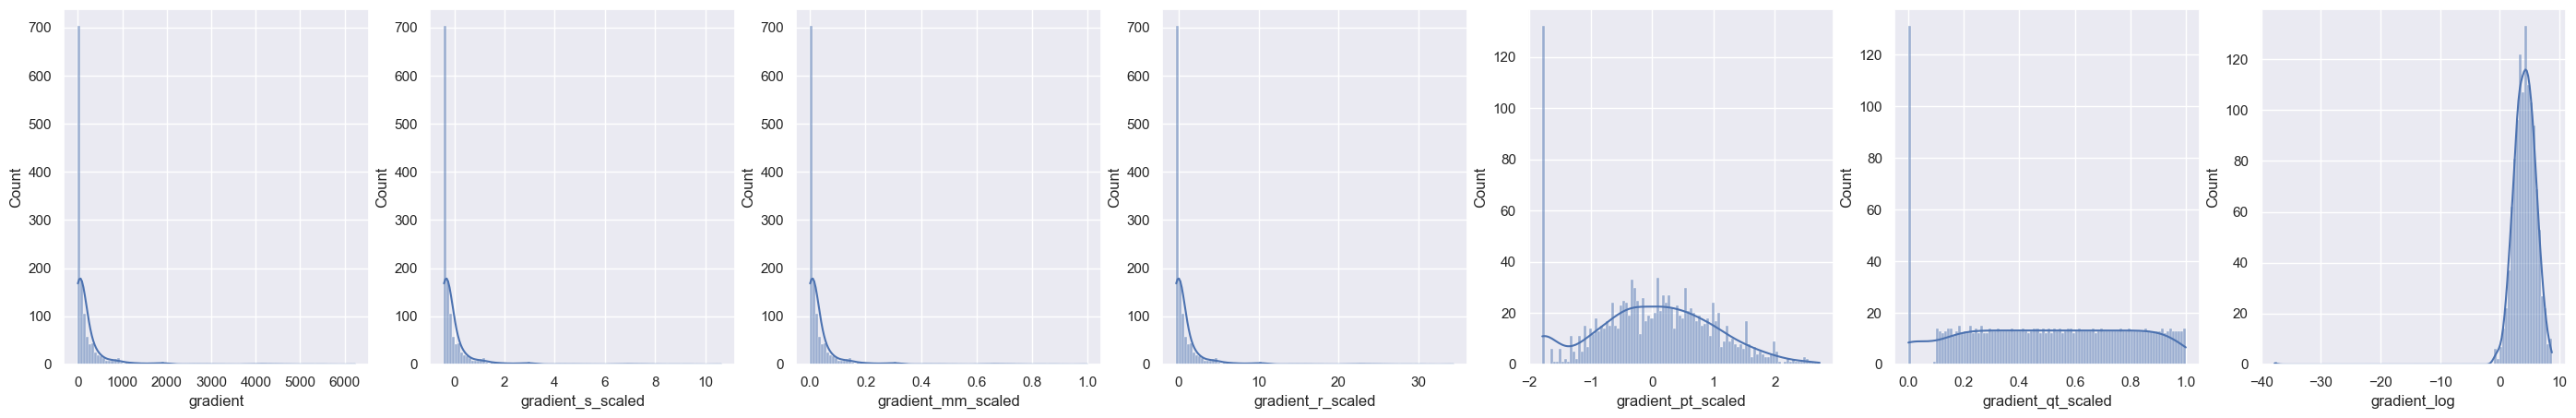

In [62]:
# plotting the distribution of gradient and scaled gradients for each article on multi plot

fig, ax = plt.subplots(1, 7, figsize=(35, 5))
sns.histplot(data=df_labelled, x='gradient', bins=100, kde=True, ax=ax[0])
sns.histplot(data=df_labelled, x='gradient_s_scaled', bins=100, kde=True, ax=ax[1])
sns.histplot(data=df_labelled, x='gradient_mm_scaled', bins=100, kde=True, ax=ax[2])
sns.histplot(data=df_labelled, x='gradient_r_scaled', bins=100, kde=True, ax=ax[3])
sns.histplot(data=df_labelled, x='gradient_pt_scaled', bins=100, kde=True, ax=ax[4])
sns.histplot(data=df_labelled, x='gradient_qt_scaled', bins=100, kde=True, ax=ax[5])
sns.histplot(data=df_labelled, x='gradient_log', bins=100, kde=True, ax=ax[6])
plt.show()


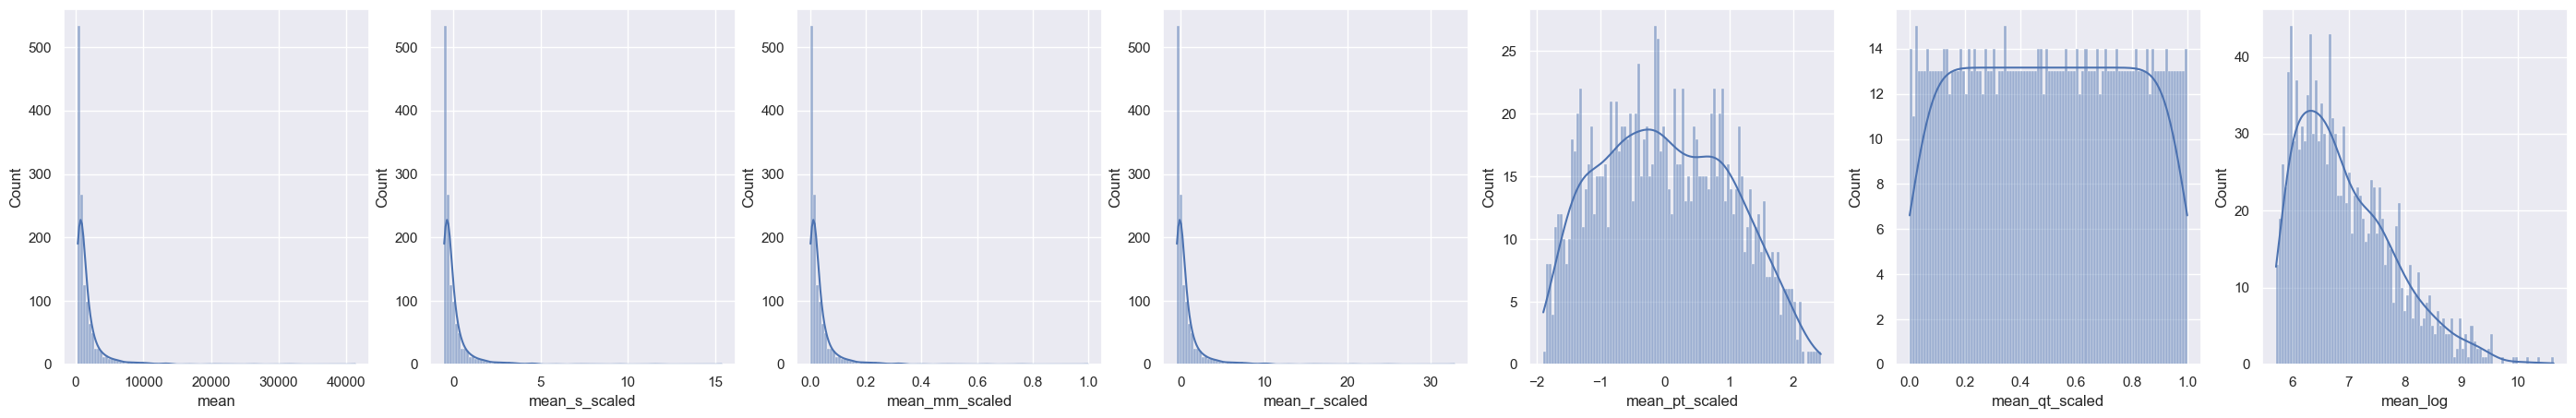

In [63]:
# plotting the distribution of mean  and scaled means for each article on multi plot

fig, ax = plt.subplots(1, 7, figsize=(35,5))
sns.histplot(data=df_labelled, x='mean', bins=100, kde=True, ax=ax[0])
sns.histplot(data=df_labelled, x='mean_s_scaled', bins=100, kde=True, ax=ax[1])
sns.histplot(data=df_labelled, x='mean_mm_scaled', bins=100, kde=True, ax=ax[2])
sns.histplot(data=df_labelled, x='mean_r_scaled', bins=100, kde=True, ax=ax[3])
sns.histplot(data=df_labelled, x='mean_pt_scaled', bins=100, kde=True, ax=ax[4])
sns.histplot(data=df_labelled, x='mean_qt_scaled', bins=100, kde=True, ax=ax[5])
sns.histplot(data=df_labelled, x='mean_log', bins=100, kde=True, ax=ax[6])
plt.show()


In [64]:
df_labelled.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,hours_since_published,...,mean_mm_scaled,gradient_mm_scaled,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,mean_log,gradient_log
0,2023-05-02 00:56:12,Celebrity beauty files: Naomi Yeo on becoming ...,â€œIâ€™m a bit of a late bloomer coming into f...,https://www.facebook.com/93889432933_101596052...,cnalifestyle.channelnewsasia.com,321,2023-05-04,general,4d/toto,0.000000,...,0.000816,0.001026,-0.421533,-0.265851,-1.664224,-0.922317,0.026026,0.178178,5.818598,1.856298
1,2023-05-02 06:30:13,Feel compelled to chop it all off? This may be...,"The ""Ur hair holds memories"" TikTok trend is s...",https://www.facebook.com/345185573000_61926142...,sg.news.yahoo.com,310,2023-05-04,general,4d/toto,5.566944,...,0.002470,0.007199,-0.366464,-0.051724,-1.290496,-0.052755,0.121024,0.471354,6.002404,3.804438
2,2023-05-03 09:20:01,Blackpink's Jisoo breaks bandmate Lisa's Spoti...,Flower took just 32 days to hit 100 million st...,https://www.facebook.com/129011692114_10159186...,straitstimes.com,1025,2023-05-04,general,4d/toto,26.830000,...,0.234606,0.655684,7.361841,22.443270,1.963335,2.461237,0.984006,0.994103,9.203658,8.316178
3,2023-05-03 11:30:45,'Run slow to run fast': Woman shares tips to k...,For those who want to start running but are no...,https://www.facebook.com/121790674546188_63771...,asiaone.com,746,2023-05-04,general,4d/toto,2.178889,...,0.099324,0.225461,2.858029,7.519466,1.522910,1.811109,0.926739,0.965850,8.384850,7.248646
4,2023-05-04 05:52:42,"Sâ€™pore Woman Shares Tips For Runners, Encour...",She says that building stamina and getting com...,https://www.facebook.com/292279440975148_55702...,mustsharenews.com,386,2023-05-07,general,4d/toto,18.365833,...,0.002176,0.001523,-0.376250,-0.248610,-1.349933,-0.761755,0.097629,0.216717,5.972112,2.251292


In [65]:
GRD_THRESHOLD_UPPER = 1
GRD_THRESHOLD_LOWER = -1
VAL_ARR_THRESHOLD_UPPER = 1
VAL_ARR_THRESHOLD_LOWER = -1

def get_label(row, colums):
    gradient_index = colums.index('gradient_pt_scaled')
    mean_index = colums.index('mean_pt_scaled')

    if row[gradient_index] > GRD_THRESHOLD_UPPER or row[mean_index] > VAL_ARR_THRESHOLD_UPPER:
        return "trending"
    
    elif row[gradient_index] < GRD_THRESHOLD_LOWER or row[mean_index] < VAL_ARR_THRESHOLD_LOWER:
        return "diminishing"
    
    else:
        return "neutral"

In [66]:
# label each row

df_labelled['label'] = df_labelled.apply(lambda x: get_label(x, list(df_labelled.columns)), axis=1)
df_labelled.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,hours_since_published,...,gradient_mm_scaled,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,mean_log,gradient_log,label
0,2023-05-02 00:56:12,Celebrity beauty files: Naomi Yeo on becoming ...,â€œIâ€™m a bit of a late bloomer coming into f...,https://www.facebook.com/93889432933_101596052...,cnalifestyle.channelnewsasia.com,321,2023-05-04,general,4d/toto,0.000000,...,0.001026,-0.421533,-0.265851,-1.664224,-0.922317,0.026026,0.178178,5.818598,1.856298,diminishing
1,2023-05-02 06:30:13,Feel compelled to chop it all off? This may be...,"The ""Ur hair holds memories"" TikTok trend is s...",https://www.facebook.com/345185573000_61926142...,sg.news.yahoo.com,310,2023-05-04,general,4d/toto,5.566944,...,0.007199,-0.366464,-0.051724,-1.290496,-0.052755,0.121024,0.471354,6.002404,3.804438,diminishing
2,2023-05-03 09:20:01,Blackpink's Jisoo breaks bandmate Lisa's Spoti...,Flower took just 32 days to hit 100 million st...,https://www.facebook.com/129011692114_10159186...,straitstimes.com,1025,2023-05-04,general,4d/toto,26.830000,...,0.655684,7.361841,22.443270,1.963335,2.461237,0.984006,0.994103,9.203658,8.316178,trending
3,2023-05-03 11:30:45,'Run slow to run fast': Woman shares tips to k...,For those who want to start running but are no...,https://www.facebook.com/121790674546188_63771...,asiaone.com,746,2023-05-04,general,4d/toto,2.178889,...,0.225461,2.858029,7.519466,1.522910,1.811109,0.926739,0.965850,8.384850,7.248646,trending
4,2023-05-04 05:52:42,"Sâ€™pore Woman Shares Tips For Runners, Encour...",She says that building stamina and getting com...,https://www.facebook.com/292279440975148_55702...,mustsharenews.com,386,2023-05-07,general,4d/toto,18.365833,...,0.001523,-0.376250,-0.248610,-1.349933,-0.761755,0.097629,0.216717,5.972112,2.251292,diminishing


### EDA of target variables

In [67]:
# Perform basic data exploration of target variable

df_labelled['label'].value_counts()


neutral        677
diminishing    327
trending       313
Name: label, dtype: int64

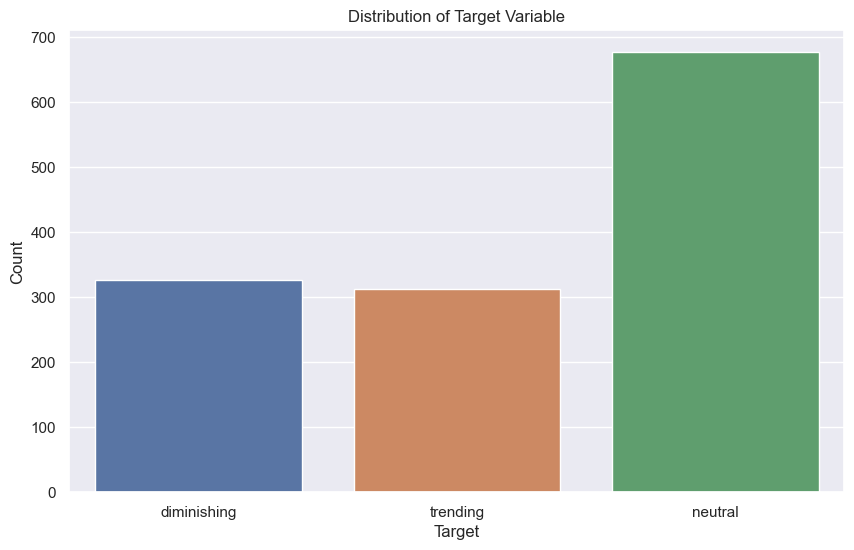

In [68]:
# Plot the distribution of target variable using Seaborn. 

plt.figure(figsize=(10, 6))
sns.countplot(data=df_labelled, x='label')
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [69]:
# merge the labelled dataframe with the original dataframe to get the full dataset with labels

df_combined = df.merge(df_labelled[['link', 'label']], on='link', how='left')
df_combined.head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,facebook_interactions_abs_change,label
0,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,general,others,0.0,neutral
1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05,general,others,101.0,neutral
2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07,general,others,182.0,neutral
3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08,general,others,49.0,neutral
4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09,general,others,25.0,neutral


In [70]:
unique_articles = df_combined['link'].unique()
new_df = pd.DataFrame()

for article in unique_articles:
    df_slice = df_combined[df_combined['link'] == article].reset_index(drop=True)
    df_slice = df_slice.reset_index().rename(columns={'index': 'day'})
    df_slice['day'] = df_slice['day'] + 1

    new_df = new_df.append(df_slice)

new_df.head(20)

,day,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,facebook_interactions_abs_change,label
0,1,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1351,2023-05-04,general,others,0.0,neutral
1,2,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1452,2023-05-05,general,others,101.0,neutral
2,3,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1634,2023-05-07,general,others,182.0,neutral
3,4,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1683,2023-05-08,general,others,49.0,neutral
4,5,2023-05-02 08:00:05,â€˜The Godfather of AIâ€™ leaves Google and wa...,Mr Geoffrey Hinton said he has quit his job at...,https://www.facebook.com/147858757571_10160136...,todayonline.com,1708,2023-05-09,general,others,25.0,neutral
0,1,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1336,2023-05-04,general,others,0.0,neutral
1,2,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1514,2023-05-05,general,others,178.0,neutral
2,3,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1837,2023-05-07,general,others,323.0,neutral
3,4,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1849,2023-05-08,general,others,12.0,neutral
4,5,2023-05-02 06:40:00,â€˜The Godfather of AI' leaves Google and warn...,â€œIt is hard to see how you can prevent the b...,https://www.facebook.com/129011692114_10159184...,straitstimes.com,1852,2023-05-09,general,others,3.0,neutral


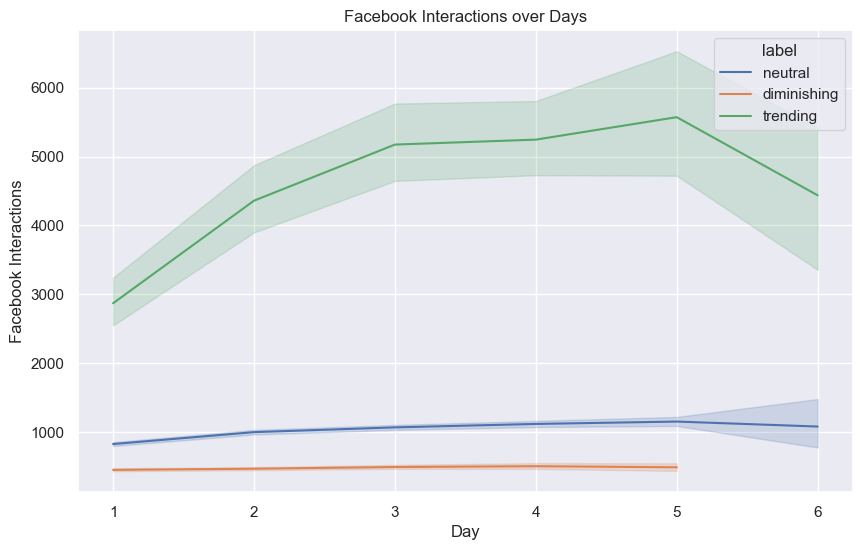

In [71]:
# Plot the facebook interactions for each article over days, coloured by label

plt.figure(figsize=(10, 6))
sns.lineplot(data=new_df, x='day', y='facebook_interactions', hue='label')
plt.title('Facebook Interactions over Days')
plt.xlabel('Day')
plt.ylabel('Facebook Interactions')
plt.show()

In [72]:
# previewing trending articles

df_labelled[df_labelled['label'] == 'trending'].head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,hours_since_published,...,gradient_mm_scaled,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,mean_log,gradient_log,label
2,2023-05-03 09:20:01,Blackpink's Jisoo breaks bandmate Lisa's Spoti...,Flower took just 32 days to hit 100 million st...,https://www.facebook.com/129011692114_10159186...,straitstimes.com,1025,2023-05-04,general,4d/toto,26.830000,...,0.655684,7.361841,22.443270,1.963335,2.461237,0.984006,0.994103,9.203658,8.316178,trending
3,2023-05-03 11:30:45,'Run slow to run fast': Woman shares tips to k...,For those who want to start running but are no...,https://www.facebook.com/121790674546188_63771...,asiaone.com,746,2023-05-04,general,4d/toto,2.178889,...,0.225461,2.858029,7.519466,1.522910,1.811109,0.926739,0.965850,8.384850,7.248646,trending
6,2023-05-07 10:42:38,"S'pore man asks ChatGPT for Toto numbers, wins...",Why opt for Quick Pick when you can ask ChatGPT?,https://www.facebook.com/592308557475467_66022...,mothership.sg,2277,2023-05-08,general,4d/toto,20.700556,...,0.039105,1.870195,1.055061,1.295487,0.818761,0.882216,0.788514,8.059023,5.496758,trending
11,2023-05-11 06:25:34,Sâ€™porean woman 1 of 10 in world to win US$10...,Huat ah!,https://www.facebook.com/592308557475467_66153...,mothership.sg,5521,2023-05-12,general,4d/toto,20.885000,...,0.141655,6.137348,4.612347,1.887582,1.538971,0.975968,0.938995,9.038793,6.783891,trending
14,2023-05-11 09:30:01,NewJeans is the fastest group to achieve a bil...,#NewJeans overtook a BLACKPINK member ðŸ˜³,https://www.facebook.com/345185573000_62467126...,sg.style.yahoo.com,7331,2023-05-13,general,4d/toto,1.023056,...,0.221356,6.598743,7.377086,1.918306,1.800227,0.979009,0.965135,9.104146,7.230273,trending


In [73]:
# previewing not trending articles

df_labelled[df_labelled['label'] == 'diminishing'].head()

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,hours_since_published,...,gradient_mm_scaled,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,mean_log,gradient_log,label
0,2023-05-02 00:56:12,Celebrity beauty files: Naomi Yeo on becoming ...,â€œIâ€™m a bit of a late bloomer coming into f...,https://www.facebook.com/93889432933_101596052...,cnalifestyle.channelnewsasia.com,321,2023-05-04,general,4d/toto,0.000000,...,0.001026,-0.421533,-0.265851,-1.664224,-0.922317,0.026026,0.178178,5.818598,1.856298,diminishing
1,2023-05-02 06:30:13,Feel compelled to chop it all off? This may be...,"The ""Ur hair holds memories"" TikTok trend is s...",https://www.facebook.com/345185573000_61926142...,sg.news.yahoo.com,310,2023-05-04,general,4d/toto,5.566944,...,0.007199,-0.366464,-0.051724,-1.290496,-0.052755,0.121024,0.471354,6.002404,3.804438,diminishing
4,2023-05-04 05:52:42,"Sâ€™pore Woman Shares Tips For Runners, Encour...",She says that building stamina and getting com...,https://www.facebook.com/292279440975148_55702...,mustsharenews.com,386,2023-05-07,general,4d/toto,18.365833,...,0.001523,-0.376250,-0.248610,-1.349933,-0.761755,0.097629,0.216717,5.972112,2.251292,diminishing
8,2023-05-09 02:55:01,"Jack Neo is making I Not Stupid 3, has started...",Among the roles being cast are students and mo...,https://www.facebook.com/93889432933_101596205...,cnalifestyle.channelnewsasia.com,485,2023-05-12,general,4d/toto,12.880833,...,0.000561,-0.297310,-0.281980,-0.933689,-1.145735,0.213376,0.137137,6.193725,1.252763,diminishing
10,2023-05-10 09:32:28,Lift it to win it: Chinese city attracts touri...,"Unexpectedly, an elderly man was the only one ...",https://www.facebook.com/121790674546188_64007...,asiaone.com,533,2023-05-12,general,4d/toto,4.165833,...,0.000738,-0.252433,-0.275862,-0.747345,-1.048198,0.265219,0.154154,6.300786,1.526056,diminishing


In [74]:
# concatenate headline and summary columns
df_labelled['text'] = df_labelled['headline'] + ' ' + df_labelled['summary']

In [75]:
df_labelled

,published,headline,summary,link,domain,facebook_interactions,date_extracted,article_theme,article_index,hours_since_published,...,mean_r_scaled,gradient_r_scaled,mean_pt_scaled,gradient_pt_scaled,mean_qt_scaled,gradient_qt_scaled,mean_log,gradient_log,label,text
0,2023-05-02 00:56:12,Celebrity beauty files: Naomi Yeo on becoming ...,â€œIâ€™m a bit of a late bloomer coming into f...,https://www.facebook.com/93889432933_101596052...,cnalifestyle.channelnewsasia.com,321,2023-05-04,general,4d/toto,0.000000,...,-0.421533,-0.265851,-1.664224,-0.922317,0.026026,0.178178,5.818598,1.856298,diminishing,Celebrity beauty files: Naomi Yeo on becoming ...
1,2023-05-02 06:30:13,Feel compelled to chop it all off? This may be...,"The ""Ur hair holds memories"" TikTok trend is s...",https://www.facebook.com/345185573000_61926142...,sg.news.yahoo.com,310,2023-05-04,general,4d/toto,5.566944,...,-0.366464,-0.051724,-1.290496,-0.052755,0.121024,0.471354,6.002404,3.804438,diminishing,Feel compelled to chop it all off? This may be...
2,2023-05-03 09:20:01,Blackpink's Jisoo breaks bandmate Lisa's Spoti...,Flower took just 32 days to hit 100 million st...,https://www.facebook.com/129011692114_10159186...,straitstimes.com,1025,2023-05-04,general,4d/toto,26.830000,...,7.361841,22.443270,1.963335,2.461237,0.984006,0.994103,9.203658,8.316178,trending,Blackpink's Jisoo breaks bandmate Lisa's Spoti...
3,2023-05-03 11:30:45,'Run slow to run fast': Woman shares tips to k...,For those who want to start running but are no...,https://www.facebook.com/121790674546188_63771...,asiaone.com,746,2023-05-04,general,4d/toto,2.178889,...,2.858029,7.519466,1.522910,1.811109,0.926739,0.965850,8.384850,7.248646,trending,'Run slow to run fast': Woman shares tips to k...
4,2023-05-04 05:52:42,"Sâ€™pore Woman Shares Tips For Runners, Encour...",She says that building stamina and getting com...,https://www.facebook.com/292279440975148_55702...,mustsharenews.com,386,2023-05-07,general,4d/toto,18.365833,...,-0.376250,-0.248610,-1.349933,-0.761755,0.097629,0.216717,5.972112,2.251292,diminishing,"Sâ€™pore Woman Shares Tips For Runners, Encour..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,2023-05-15 20:41:08,Ronaldo coming to S'pore again in June 2023,Ronaldo is coming to Singapore again.,https://www.facebook.com/592308557475467_66311...,mothership.sg,480,2023-05-17,sports,world cup,103.182778,...,-0.211611,0.179644,-0.600379,0.274353,0.316206,0.600255,6.389121,4.460144,neutral,Ronaldo coming to S'pore again in June 2023 Ro...
1313,2023-05-16 03:56:42,Cristiano Ronaldo to visit Singapore in June,"""Looking forward to see all of you again next ...",https://www.facebook.com/93889432933_101596341...,channelnewsasia.com,998,2023-05-17,sports,world cup,7.259444,...,0.211273,-0.028365,0.289337,-0.008987,0.605607,0.483483,7.018178,3.893859,neutral,"Cristiano Ronaldo to visit Singapore in June ""..."
1314,2023-05-20 06:59:04,Fan goes overboard groping Jackson Wang at Bra...,Some fans called it out as an example of haras...,https://www.facebook.com/592308557475467_66463...,mothership.sg,364,2023-05-22,sports,world cup,99.039444,...,-0.399230,-0.301446,-1.500622,-1.788141,0.056184,0.000000,5.897154,-inf,diminishing,Fan goes overboard groping Jackson Wang at Bra...
1315,2023-05-20 09:00:14,Singer Jackson Wang groped by fan onstage duri...,"The fan hugged Wang and, at one point, moved h...",https://www.facebook.com/129011692114_10159217...,straitstimes.com,2749,2023-05-21,sports,world cup,2.019444,...,2.312044,10.354839,1.410732,1.995876,0.906512,0.980809,8.217978,7.557995,trending,Singer Jackson Wang groped by fan onstage duri...


In [76]:
df_labelled['label'].value_counts().sort_values(ascending=False)

neutral        677
diminishing    327
trending       313
Name: label, dtype: int64

In [77]:
# getting label for each article_theme based on mode of labels for each article_theme

aggregated_labels = df_labelled.groupby('article_index')['label'].agg(lambda x:x.value_counts().sort_values(ascending=False).index[0]).reset_index()
aggregated_labels

,article_index,label
0,4d/toto,trending
1,banks,diminishing
2,border reopening,neutral
3,budget,diminishing
4,case numbers,neutral
5,chicken supply,diminishing
6,coe prices,neutral
7,core inflation,diminishing
8,crypto,neutral
9,currency,neutral


In [78]:
df_labelled.groupby('article_index').count()['link'].sort_values(ascending=False).reset_index()

,article_index,link
0,others,644
1,sea games,208
2,food prices,81
3,ndp,52
4,football,40
5,border reopening,39
6,4d/toto,32
7,weather,25
8,deaths,15
9,scams,13


In [79]:
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
aggregated_labels['label'] = aggregated_labels['label'].map(label_mapper)
aggregated_labels

,article_index,label
0,4d/toto,2
1,banks,0
2,border reopening,1
3,budget,0
4,case numbers,1
5,chicken supply,0
6,coe prices,1
7,core inflation,0
8,crypto,1
9,currency,1


In [80]:
aggregated_labels.sort_values(by='label', ascending=False)

,article_index,label
0,4d/toto,2
17,hari raya,2
42,vaccination,2
28,ndr,2
23,local athletes,2
46,world cup,1
22,layoffs,1
36,sea games,1
35,scams,1
34,safe management measures,1


## Deep Learning Approaches

1. SetFit with Text Features only (Summary + Headline)
2. SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Mean Monthly Visits + Mean Monthly Unqiue Visitors)
3. Combined models - Concat text embeddings with numerical features

#### 1. SetFit with Text Features only (Summary + Headline)


In [81]:
from datasets import load_dataset, Features, Value
from sentence_transformers import SentenceTransformer
from sentence_transformers.losses import CosineSimilarityLoss
from setfit import SetFitModel, SetFitTrainer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
def evaluate_predictions(test_y, pred_y):

    # macro
    acc = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y, average='macro')
    recall = recall_score(test_y, pred_y, average='macro')
    f1 = f1_score(test_y, pred_y, average='macro')

    # construct a dataframe to store the evaluation metrics
    df_eval = pd.DataFrame({'accuracy': [acc], 'precision': [precision], 'recall': [recall], 'f1': [f1]})
    df_eval = df_eval.round(3)
    return df_eval.T.rename(columns={0: 'macro'})


def plot_confusion_matrix(test_y, pred_y):
    cm = confusion_matrix(test_y, pred_y, labels=[0, 1, 2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # adjust labels
    plt.xticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.yticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.show()

In [38]:
df_labelled_m1 = df_labelled.copy()
df_labelled_m1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1317 entries, 0 to 1316
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   published                     1317 non-null   datetime64[ns]
 1   headline                      1317 non-null   object        
 2   summary                       1317 non-null   object        
 3   link                          1317 non-null   object        
 4   domain                        1317 non-null   object        
 5   facebook_interactions         1317 non-null   int64         
 6   date_extracted                1317 non-null   datetime64[ns]
 7   article_theme                 1317 non-null   object        
 8   article_index                 1317 non-null   object        
 9   domain_group                  1317 non-null   object        
 10  mean_monthly_visits           1317 non-null   int64         
 11  mean_monthly_unique_visitors  

In [39]:
df_train_test_m1 = df_labelled_m1[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'article_index', 'label']]
df_train_test_m1

,text,mean_monthly_visits,mean_monthly_unique_visitors,article_index,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,others,neutral
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,others,neutral
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,4d/toto,neutral
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,sea games,neutral
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,sea games,neutral
...,...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,others,neutral
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,healthcare,neutral
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,others,diminishing
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,ndp,trending


In [40]:
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m1['label'] = df_train_test_m1['label'].map(label_mapper)

# Train test split

train_df_m1, test_df_m1 = train_test_split(df_train_test_m1, test_size=0.2, random_state=42, stratify=df_train_test_m1['label'])

train_df_m1.to_parquet('data/train_df_m1.parquet')
test_df_m1.to_parquet('data/test_df_m1.parquet')

dataset_m1 = load_dataset("parquet", data_files={'train': "data/train_df_m1.parquet", 'test': "data/test_df_m1.parquet"})
train_dataset_m1 = dataset_m1["train"]
test_dataset_m1 = dataset_m1["test"]

C:\Users\edmun\AppData\Local\Temp\ipykernel_37108\4172689601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m1['label'] = df_train_test_m1['label'].map(label_mapper)


Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 335.57it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-10842bdd8d51671a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 999.83it/s]


In [41]:
# Load a SetFit model
model_m1 = SetFitModel.from_pretrained(
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
    cache_dir="cached_models",
)

# Create trainer
trainer_m1 = SetFitTrainer(
    model=model_m1,
    train_dataset=train_dataset_m1,
    eval_dataset=test_dataset_m1,
    loss_class=CosineSimilarityLoss,
    # metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [42]:
trainer_m1.train()

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 47.29it/s]
***** Running training *****
  Num examples = 42120
  Num epochs = 1
  Total optimization steps = 2633
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [03:20<00:00, 200.46s/it]


In [54]:
# evalutating pred_y against test_y

def evaluate_predictions(test_y, pred_y):

    # macro
    acc = accuracy_score(test_y, pred_y)
    precision = precision_score(test_y, pred_y, average='macro')
    recall = recall_score(test_y, pred_y, average='macro')
    f1 = f1_score(test_y, pred_y, average='macro')

    # construct a dataframe to store the evaluation metrics
    df_eval = pd.DataFrame({'accuracy': [acc], 'precision': [precision], 'recall': [recall], 'f1': [f1]})
    df_eval = df_eval.round(3)
    return df_eval.T.rename(columns={0: 'macro'})

def get_predictions_agg(test_dataset, pred_y):
    if not isinstance(test_dataset, pd.DataFrame):
        test_dataset_merge = test_dataset.to_pandas()
    else:
        test_dataset_merge = test_dataset.copy()
    test_dataset_merge['pred_y'] = pred_y
    test_dataset_agg = test_dataset_merge.groupby('article_index')['label'].agg(lambda x:x.value_counts().sort_values(ascending=False).index[0]).reset_index()
    pred_agg = test_dataset_merge.groupby('article_index')['pred_y'].agg(lambda x:x.value_counts().sort_values(ascending=False).index[0]).reset_index()
    return test_dataset_agg, pred_agg
    # return test_dataset_agg['label'], pred_agg['pred_y']

In [55]:
test_y_agg_m1_, pred_y_agg_m1_ = get_predictions_agg(test_dataset_m1, pred_y_m1)


In [59]:
pred_y_agg_m1_.sort_values(by='pred_y', ascending=False)

,article_index,pred_y
26,scams,2
5,core inflation,2
16,layoffs,2
23,parliament,2
1,banks,2
4,chicken supply,2
31,weather,2
30,teachers,1
29,support measures,1
27,sea games,1


In [57]:
test_y_agg_m1_.sort_values(by='label', ascending=False)

,article_index,label
16,layoffs,2
31,weather,2
12,hari raya,2
0,4d/toto,1
30,teachers,1
27,sea games,1
26,scams,1
24,petrol prices,1
23,parliament,1
22,others,1


In [44]:
test_y_m1 = test_dataset_m1.to_pandas()['label']
pred_y_m1 = model_m1.predict(test_dataset_m1.to_pandas()['text']).numpy()

res_m1 = evaluate_predictions(test_y_m1, pred_y_m1)
res_m1

,macro
accuracy,0.447
precision,0.405
recall,0.378
f1,0.382


In [45]:
test_y_agg_m1, pred_y_agg_m1 = get_predictions_agg(test_dataset_m1, pred_y_m1)
res_agg_m1 = evaluate_predictions(test_y_agg_m1, pred_y_agg_m1)
res_agg_m1

,macro
accuracy,0.618
precision,0.554
recall,0.554
f1,0.491


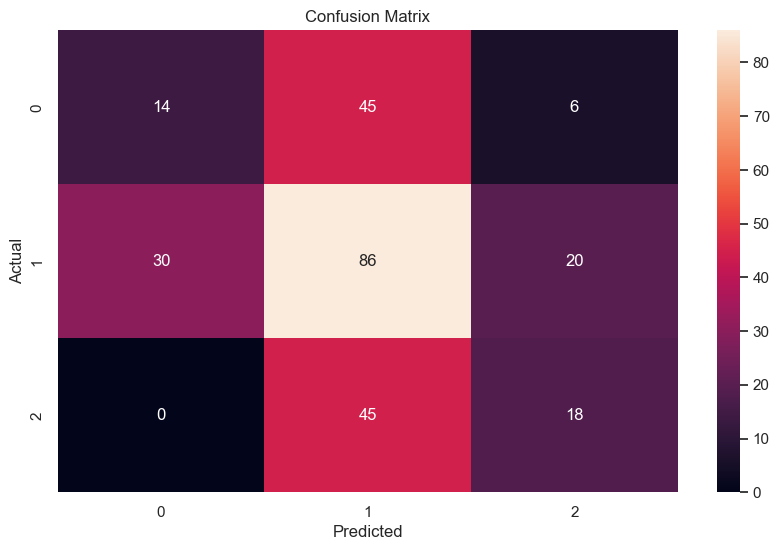

In [46]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, pred_y):
    cm = confusion_matrix(test_y, pred_y, labels=[0, 1, 2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # adjust labels
    plt.xticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.yticks([0.5, 1.5, 2.5], ['0', '1', '2'])
    plt.show()

plot_confusion_matrix(test_y_m1, pred_y_m1)

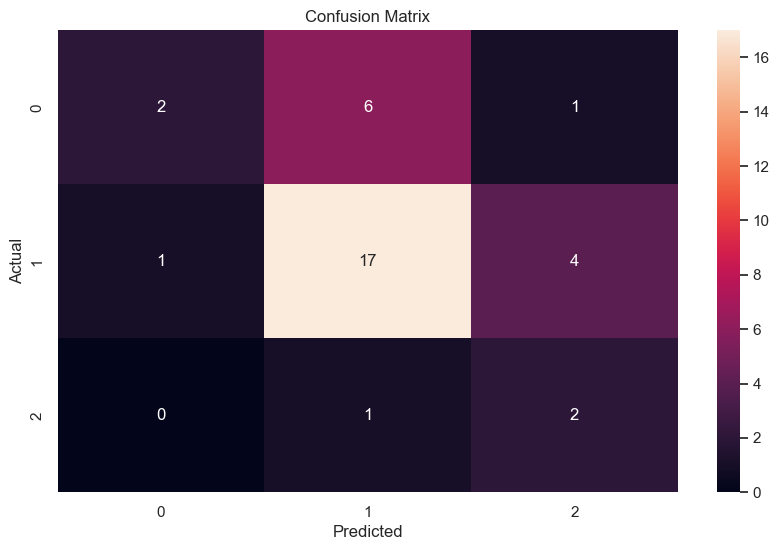

In [47]:
plot_confusion_matrix(test_y_agg_m1, pred_y_agg_m1)

### 2. SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Mean Monthly Visits + Mean Monthly Unqiue Visitors)

In [182]:
df_labelled_m2 = df_labelled.copy()
df_train_test_m2 = df_labelled_m2[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'article_index', 'label']]
df_train_test_m2

,text,mean_monthly_visits,mean_monthly_unique_visitors,article_index,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,others,neutral
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,others,neutral
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,4d/toto,neutral
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,sea games,neutral
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,sea games,neutral
...,...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,others,neutral
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,healthcare,neutral
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,others,diminishing
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,ndp,trending


In [183]:
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m2['label'] = df_train_test_m2['label'].map(label_mapper)


# combine mean_monthly_visits and mean_monthly_unique_visitors into text as text features

df_train_test_m2['text'] = df_train_test_m2['text'] + ' There are ' + df_train_test_m2['mean_monthly_visits'].astype(str) + ' mean monthly visitors to the website and ' + df_train_test_m2['mean_monthly_unique_visitors'].astype(str) + ' mean monthly unique visitors to the website.'
df_train_test_m2.drop(columns=['mean_monthly_visits', 'mean_monthly_unique_visitors'], inplace=True)
df_train_test_m2.head()

C:\Users\edmun\AppData\Local\Temp\ipykernel_24372\1153938972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2['label'] = df_train_test_m2['label'].map(label_mapper)
C:\Users\edmun\AppData\Local\Temp\ipykernel_24372\1153938972.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2['text'] = df_train_test_m2['text'] + ' There are ' + df_train_test_m2['mean_monthly_visits'].astype(str) + ' mean monthly visitors to the website and ' + df_train_test_m2['mean_monthly_unique_visit

,text,article_index,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,others,1
1,â€˜The Godfather of AI' leaves Google and warn...,others,1
2,â€˜She left an incredible legacy': Tributes po...,4d/toto,1
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,sea games,1
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,sea games,1


In [42]:
df_train_test_m2.iloc[0].text

'â€˜The Godfather of AIâ€™ leaves Google and warns of danger ahead Mr Geoffrey Hinton said he has quit his job at Google, where he has worked for more than decade and became one of the most respected voices in the field, so he can freely speak out about the risks of AI. A part of him, he said, now regrets his lifeâ€™s work.\n\n(via The New York Times) There are 3660000 mean monthly visitors to the website and 1170000 mean monthly unique visitors to the website.'

In [184]:
# Train test split

train_df_m2, test_df_m2 = train_test_split(df_train_test_m2, test_size=0.2, random_state=42, stratify=df_train_test_m2['label'])

train_df_m2.to_parquet('data/train_df_m2.parquet')
test_df_m2.to_parquet('data/test_df_m2.parquet')


dataset_m2 = load_dataset("parquet", data_files={'train': "data/train_df_m2.parquet", 'test': "data/test_df_m2.parquet"})
train_dataset_m2 = dataset_m2["train"]
test_dataset_m2 = dataset_m2["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 993.09it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-a79c71dfb648f3cd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 664.71it/s]


In [185]:
# Load a SetFit model
model_m2 = SetFitModel.from_pretrained(
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
    cache_dir="cached_models",
)

# Create trainer
trainer_m2 = SetFitTrainer(
    model=model_m2,
    train_dataset=train_dataset_m2,
    eval_dataset=test_dataset_m2,
    loss_class=CosineSimilarityLoss,
    # metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [186]:
trainer_m2.train()

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 33.18it/s]
***** Running training *****
  Num examples = 42120
  Num epochs = 1
  Total optimization steps = 2633
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [04:01<00:00, 241.88s/it]


In [187]:
test_y_m2 = test_dataset_m2.to_pandas()['label']
pred_y_m2 = model_m2.predict(test_dataset_m2.to_pandas()['text']).numpy()

In [188]:
test_y_m2 = test_dataset_m2.to_pandas()['label']
pred_y_m2 = model_m2.predict(test_dataset_m2.to_pandas()['text']).numpy()

res_m2 = evaluate_predictions(test_y_m2, pred_y_m2)
res_m2


,macro
accuracy,0.496
precision,0.459
recall,0.427
f1,0.432


In [263]:
test_y_agg_m2, pred_y_agg_m2 = get_predictions_agg(test_dataset_m2, pred_y_m2)
res_agg_m2 = evaluate_predictions(test_y_agg_m2, pred_y_agg_m2)
res_agg_m2

,macro
accuracy,0.588
precision,0.453
recall,0.421
f1,0.385


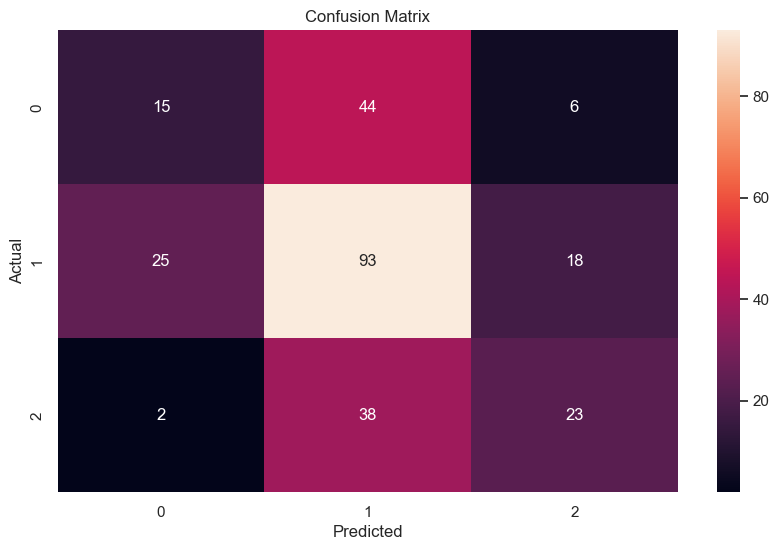

In [190]:
plot_confusion_matrix(test_y_m2, pred_y_m2)

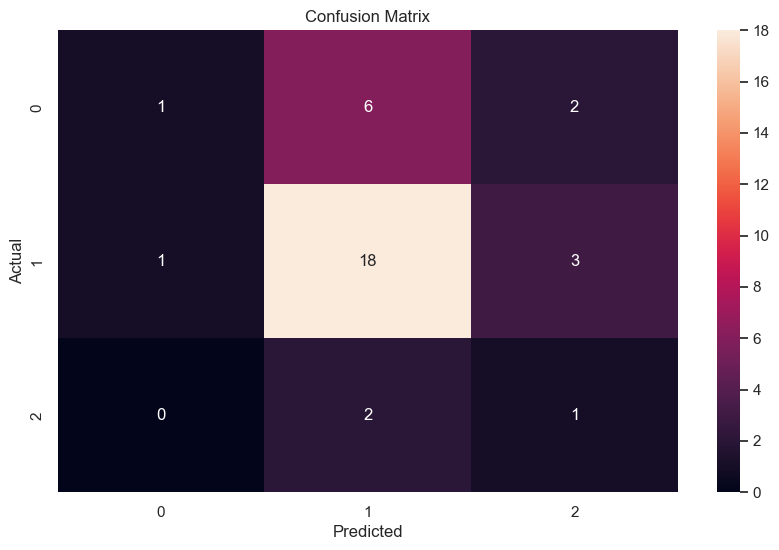

In [191]:
plot_confusion_matrix(test_y_agg_m2, pred_y_agg_m2)


### 2b. SetFit with Text Features and Numerical Features concatenated as Text Features (Summary + Headline + Mean Monthly Visits + Mean Monthly Unqiue Visitors as bins)

In [202]:
df_labelled_m2b = df_labelled.copy()
df_train_test_m2b = df_labelled_m2b[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'article_index', 'label']]
df_train_test_m2b

,text,mean_monthly_visits,mean_monthly_unique_visitors,article_index,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,others,neutral
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,others,neutral
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,4d/toto,neutral
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,sea games,neutral
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,sea games,neutral
...,...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,others,neutral
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,healthcare,neutral
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,others,diminishing
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,ndp,trending


In [203]:
# Normalise mean_monthly_visits and mean_monthly_unique_visitors

df_train_test_m2b['mean_monthly_visits'] = df_train_test_m2b['mean_monthly_visits'] / df_train_test_m2b['mean_monthly_visits'].max()
df_train_test_m2b['mean_monthly_unique_visitors'] = df_train_test_m2b['mean_monthly_unique_visitors'] / df_train_test_m2b['mean_monthly_unique_visitors'].max()

# converting mean_monthly_visits and mean_monthly_unique_visitors to bin

df_train_test_m2b['mean_monthly_visits'] = df_train_test_m2b['mean_monthly_visits'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))
df_train_test_m2b['mean_monthly_unique_visitors'] = df_train_test_m2b['mean_monthly_unique_visitors'].apply(lambda x: "lowest" if x < 0.25 else ("low" if x < 0.5 else ("moderate" if x < 0.75 else "high")))

df_train_test_m2b.head(10)

C:\Users\edmun\AppData\Local\Temp\ipykernel_24372\2388436977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b['mean_monthly_visits'] = df_train_test_m2b['mean_monthly_visits'] / df_train_test_m2b['mean_monthly_visits'].max()
C:\Users\edmun\AppData\Local\Temp\ipykernel_24372\2388436977.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b['mean_monthly_unique_visitors'] = df_train_test_m2b['mean_monthly_unique_visitors'] / df_train_test_m2b['mean_monthly_unique_visitors']

,text,mean_monthly_visits,mean_monthly_unique_visitors,article_index,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,lowest,moderate,others,neutral
1,â€˜The Godfather of AI' leaves Google and warn...,high,high,others,neutral
2,â€˜She left an incredible legacy': Tributes po...,high,high,4d/toto,neutral
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,lowest,low,sea games,neutral
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,high,high,sea games,neutral
5,â€˜I now realise I cannot control everything i...,high,high,others,diminishing
6,â€˜I know what itâ€™s like to be homeless and ...,high,high,others,neutral
7,â€˜Do you think audiences are blind?â€™ Michel...,low,moderate,sea games,neutral
8,â€˜Coffee Shop King' died of haemorrhage after...,high,high,deaths,neutral
9,â€˜At least it was me and not anyone else': An...,high,high,others,neutral


In [204]:
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m2b['label'] = df_train_test_m2b['label'].map(label_mapper)


# combine mean_monthly_visits and mean_monthly_unique_visitors into text as text features

df_train_test_m2b['text'] = df_train_test_m2b['text'] + ' There are ' + df_train_test_m2b['mean_monthly_visits'].astype(str) + ' mean monthly visitors to the website and ' + df_train_test_m2b['mean_monthly_unique_visitors'].astype(str) + ' mean monthly unique visitors to the website.'
df_train_test_m2b.drop(columns=['mean_monthly_visits', 'mean_monthly_unique_visitors'], inplace=True)
df_train_test_m2b.head()

C:\Users\edmun\AppData\Local\Temp\ipykernel_24372\2171122893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b['label'] = df_train_test_m2b['label'].map(label_mapper)
C:\Users\edmun\AppData\Local\Temp\ipykernel_24372\2171122893.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m2b['text'] = df_train_test_m2b['text'] + ' There are ' + df_train_test_m2b['mean_monthly_visits'].astype(str) + ' mean monthly visitors to the website and ' + df_train_test_m2b['mean_monthly_unique

,text,article_index,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,others,1
1,â€˜The Godfather of AI' leaves Google and warn...,others,1
2,â€˜She left an incredible legacy': Tributes po...,4d/toto,1
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,sea games,1
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,sea games,1


In [195]:
df_train_test_m2b.text.iloc[0]

'â€˜The Godfather of AIâ€™ leaves Google and warns of danger ahead Mr Geoffrey Hinton said he has quit his job at Google, where he has worked for more than decade and became one of the most respected voices in the field, so he can freely speak out about the risks of AI. A part of him, he said, now regrets his lifeâ€™s work.\n\n(via The New York Times) There are lowest mean monthly visitors to the website and moderate mean monthly unique visitors to the website.'

In [205]:
# Train test split

train_df_m2b, test_df_m2b = train_test_split(df_train_test_m2b, test_size=0.2, random_state=42, stratify=df_train_test_m2b['label'])

train_df_m2b.to_parquet('data/train_df_m2b.parquet')
test_df_m2b.to_parquet('data/test_df_m2b.parquet')


dataset_m2b = load_dataset("parquet", data_files={'train': "data/train_df_m2b.parquet", 'test': "data/test_df_m2b.parquet"})
train_dataset_m2b = dataset_m2b["train"]
test_dataset_m2b = dataset_m2b["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 658.03it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-87ad15bcf83ce209/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 989.69it/s]


In [197]:
# Load a SetFit model
model_m2b = SetFitModel.from_pretrained(
    "sentence-transformers/multi-qa-MiniLM-L6-cos-v1", 
    cache_dir="cached_models",
)

# Create trainer
trainer_m2b = SetFitTrainer(
    model=model_m2b,
    train_dataset=train_dataset_m2b,
    eval_dataset=test_dataset_m2b,
    loss_class=CosineSimilarityLoss,
    # metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for contrastive learning
    column_mapping={"text": "text", "label": "label"} # Map dataset columns to text/label expected by trainer
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


In [198]:
trainer_m2b.train()

Applying column mapping to training dataset
Generating Training Pairs: 100%|██████████| 20/20 [00:00<00:00, 47.96it/s]
***** Running training *****
  Num examples = 42120
  Num epochs = 1
  Total optimization steps = 2633
  Total train batch size = 16
Epoch: 100%|██████████| 1/1 [03:51<00:00, 231.48s/it]


In [206]:
test_y_m2b = test_dataset_m2b.to_pandas()['label']
pred_y_m2b = model_m2b.predict(test_dataset_m2b.to_pandas()['text']).numpy()

In [207]:
test_y_m2b = test_dataset_m2b.to_pandas()['label']
pred_y_m2b = model_m2b.predict(test_dataset_m2b.to_pandas()['text']).numpy()

res_m2b = evaluate_predictions(test_y_m2b, pred_y_m2b)
res_m2b


,macro
accuracy,0.500
precision,0.470
recall,0.445
f1,0.453


In [262]:
test_y_agg_m2b, pred_y_agg_m2b = get_predictions_agg(test_dataset_m2b, pred_y_m2b)
res_agg_m2b = evaluate_predictions(test_y_agg_m2b, pred_y_agg_m2b)
res_agg_m2b

,macro
accuracy,0.588
precision,0.487
recall,0.465
f1,0.454


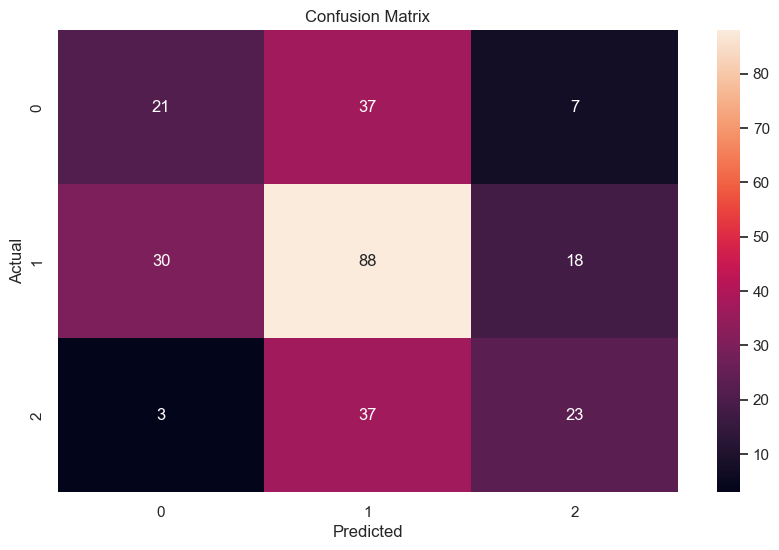

In [209]:
plot_confusion_matrix(test_y_m2b, pred_y_m2b)


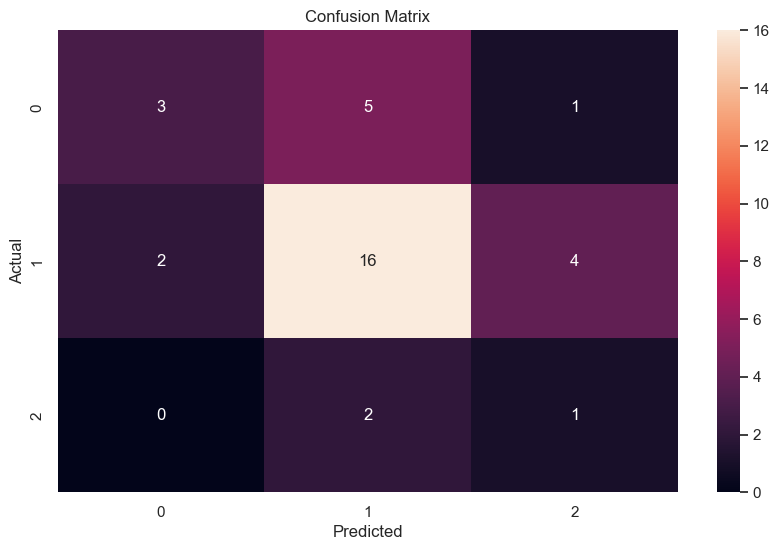

In [210]:
plot_confusion_matrix(test_y_agg_m2b, pred_y_agg_m2b)


### 3. Combined models - Concat text embeddings with numerical features

In [212]:
df_labelled_m3 = df_labelled.copy()
df_train_test_m3 = df_labelled_m3[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'article_index', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m3['label'] = df_train_test_m3['label'].map(label_mapper)
df_train_test_m3

C:\Users\edmun\AppData\Local\Temp\ipykernel_24372\2855312942.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m3['label'] = df_train_test_m3['label'].map(label_mapper)


,text,mean_monthly_visits,mean_monthly_unique_visitors,article_index,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,others,1
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,others,1
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,4d/toto,1
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,sea games,1
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,sea games,1
...,...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,others,1
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,healthcare,1
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,others,0
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,ndp,2


In [213]:
df_train_test_m3.label.value_counts()

1    677
0    327
2    313
Name: label, dtype: int64

In [214]:
# Create train, val and test datasets

train_val_df_m3, test_df_m3 = train_test_split(df_train_test_m3, test_size=0.2, random_state=42, stratify=df_train_test_m3['label'])
train_df_m3, val_df_m3 = train_test_split(train_val_df_m3, test_size=0.2, random_state=42, stratify=train_val_df_m3['label'])

In [215]:
train_df_m3.shape, val_df_m3.shape, test_df_m3.shape 

((842, 5), (211, 5), (264, 5))

In [216]:
train_df_m3.label.value_counts(), val_df_m3.label.value_counts(), test_df_m3.label.value_counts()

(1    433
 0    209
 2    200
 Name: label, dtype: int64,
 1    108
 0     53
 2     50
 Name: label, dtype: int64,
 1    136
 0     65
 2     63
 Name: label, dtype: int64)

In [217]:
# normalising mean_monthly_visits and mean_monthly_unique_visitors on train_df

from sklearn.preprocessing import MinMaxScaler

scaler_m3 = MinMaxScaler()
train_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler_m3.fit_transform(train_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
train_df_m3

# normalising mean_monthly_visits and mean_monthly_unique_visitors on val_df

val_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler_m3.transform(val_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
val_df_m3

# normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df

test_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler_m3.transform(test_df_m3[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
test_df_m3

,text,mean_monthly_visits,mean_monthly_unique_visitors,article_index,label
1103,At least 3 Mount Everest climbers killed in de...,0.832321,0.955429,mbs,1
1202,"2 fights, 4 red cards & 1 goal from Beckham: I...",0.453160,0.701374,sea games,1
392,"SEA Games 2023: One week's rest after double, ...",0.832321,0.955429,sea games,2
170,"The Big Read: Beyond IRs and new attractions, ...",1.000000,1.000000,border reopening,1
801,How Mister Donut's new employees are trained a...,1.000000,1.000000,others,1
...,...,...,...,...,...
995,Comedian in China hit with S$2.56 million fine...,0.453160,0.701374,others,2
494,Retiree forced to return to work after downloa...,0.076736,0.151862,others,0
822,Guardians of the Galaxy Vol. 3: Pom 'Mantis' K...,0.332704,0.211731,others,1
191,Taiwan Airline Pilot Allows Influencer Into Co...,0.127382,0.328548,others,1


In [218]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from torch.optim import Adam

In [219]:
# Define the numeric model
class NumericModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NumericModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the final model
class FinalModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FinalModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.log_softmax(out)
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text']  
        numeric = torch.tensor(row[['mean_monthly_visits', 'mean_monthly_unique_visitors']].apply(pd.to_numeric).values, dtype=torch.float)  
        label = torch.tensor(row['label'], dtype=torch.long) 
        return text, numeric, label


In [220]:

# Function for training
def train(dataloader, sentence_model, numeric_model, final_model, criterion, optimizer):
    final_model.train()
    numeric_model.train()
    sentence_model.train()

    total_loss = 0

    for batch in dataloader:
        # Separate the text, numeric, and label data
        text_data, numeric_data, labels = batch

        # Convert text to embeddings
        text_embeddings = sentence_model.encode(text_data)

        # Pass numeric data through our numeric model
        numeric_embeddings = numeric_model(numeric_data)

        # Concatenate text and numeric embeddings
        combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

        # Pass through the final model
        predictions = final_model(combined_embeddings)

        # Reshape predictions
        predictions = predictions.squeeze()

        # Compute loss
        loss = criterion(predictions, labels.long())
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

# Function for evaluation
def evaluate(dataloader, sentence_model, numeric_model, final_model, criterion):
    final_model.eval()
    numeric_model.eval()
    sentence_model.eval()
    
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            # Separate the text, numeric, and label data
            text_data, numeric_data, labels = batch

            # Convert text to embeddings
            text_embeddings = sentence_model.encode(text_data)

            # Pass numeric data through our numeric model
            numeric_embeddings = numeric_model(numeric_data)

            # Concatenate text and numeric embeddings
            combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

            # Pass through the final model
            predictions = final_model(combined_embeddings)

            # Reshape predictions
            predictions = predictions.squeeze()

            # Compute loss
            loss = criterion(predictions, labels.long())
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [221]:
# Create Datasets
train_dataset_m3 = CustomDataset(train_df_m3)
val_dataset_m3 = CustomDataset(val_df_m3)
test_dataset_m3 = CustomDataset(test_df_m3)

# Create DataLoaders
batch_size = 32  
train_dataloader_m3 = DataLoader(train_dataset_m3, batch_size=batch_size, shuffle=True)
val_dataloader_m3 = DataLoader(val_dataset_m3, batch_size=batch_size, shuffle=False)
test_dataloader_m3 = DataLoader(test_dataset_m3, batch_size=batch_size, shuffle=False)

# Instantiate SentenceTransformer
# sentence_model = SentenceTransformer('all-mpnet-base-v2')
sentence_model_m3 = SentenceTransformer('all-MiniLM-L6-v2')

# Instantiate NumericModel
numeric_model_m3 = NumericModel(2, 64, 512)  

# Instantiate FinalModel
final_model_m3 = FinalModel(896, 64, 3)

# Define the criterion and the optimizer
criterion_m3 = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer_m3 = Adam(list(numeric_model_m3.parameters()) + list(final_model_m3.parameters()) + list(sentence_model_m3.parameters()), lr=0.0001)

In [222]:
N_EPOCHS = 100

# Save train and validation losses

train_losses_m3 = []
val_losses_m3 = []

# Train and evaluate the model
for epoch in range(N_EPOCHS):  
    train_loss = train(train_dataloader_m3, sentence_model_m3, numeric_model_m3, final_model_m3, criterion_m3, optimizer_m3)
    valid_loss = evaluate(val_dataloader_m3, sentence_model_m3, numeric_model_m3, final_model_m3, criterion_m3)
    train_losses_m3.append(train_loss)
    val_losses_m3.append(valid_loss)
    print(f'Epoch {epoch}: Train Loss: {train_loss}, Validation Loss: {valid_loss}')

    # early stopping
    if epoch > 30 and val_losses_m3[epoch-1] < val_losses_m3[epoch] and val_losses_m3[epoch-2] < val_losses_m3[epoch-1]:
        break

Epoch 0: Train Loss: 1.060709140918873, Validation Loss: 1.0339424780436925
Epoch 1: Train Loss: 1.0351855909382854, Validation Loss: 1.0261180230549403
Epoch 2: Train Loss: 1.0282645203449108, Validation Loss: 1.0238997851099287
Epoch 3: Train Loss: 1.0230298748722784, Validation Loss: 1.022562665598733
Epoch 4: Train Loss: 1.0215573178397284, Validation Loss: 1.0209931305476598
Epoch 5: Train Loss: 1.0192249947124057, Validation Loss: 1.019064290182931
Epoch 6: Train Loss: 1.0117540182890716, Validation Loss: 1.0178969757897514
Epoch 7: Train Loss: 1.0195097923278809, Validation Loss: 1.016445781503405
Epoch 8: Train Loss: 1.0141397604235896, Validation Loss: 1.015076858656747
Epoch 9: Train Loss: 1.0118931134541829, Validation Loss: 1.0136604309082031
Epoch 10: Train Loss: 1.0078059015450653, Validation Loss: 1.0124490431376867
Epoch 11: Train Loss: 1.0047040979067485, Validation Loss: 1.0101668408938818
Epoch 12: Train Loss: 0.997001811310097, Validation Loss: 1.008694282599858
Epo

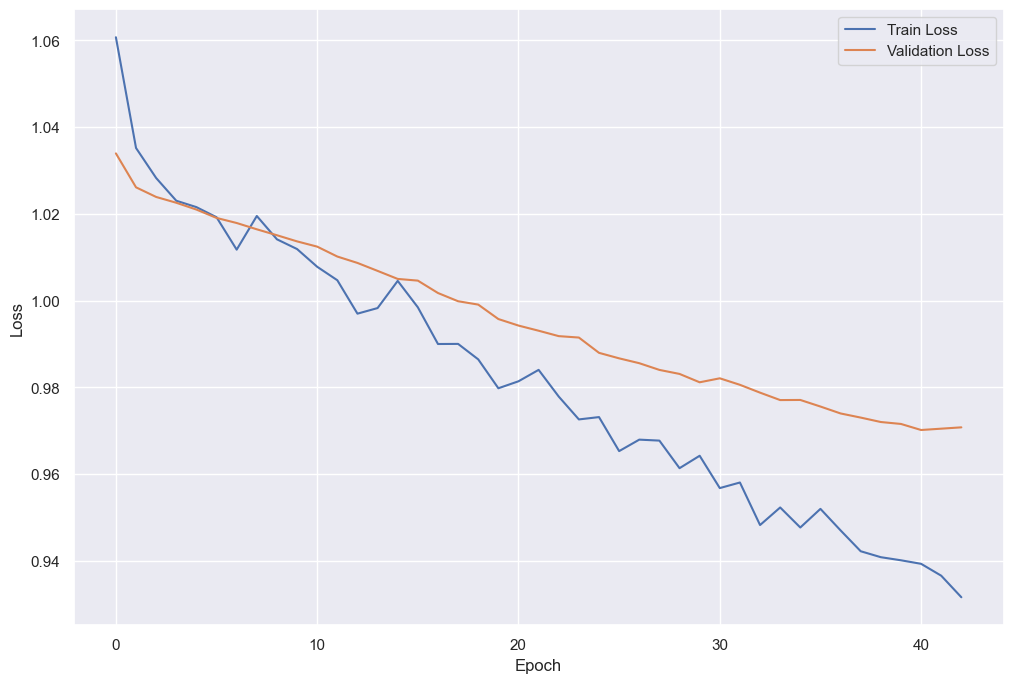

In [223]:
# Plot the train and validation losses using seaborn

plt.figure(figsize=(12, 8))
plt.plot(train_losses_m3, label='Train Loss')
plt.plot(val_losses_m3, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [224]:
final_model_m3.eval()  # Set the model to evaluation mode
sentence_model_m3.eval()
numeric_model_m3.eval()

pred_y_m3 = []  # Initialize an empty list to store predictions

with torch.no_grad():  # No need to calculate gradients for evaluation
    for texts, numerics, _ in test_dataloader_m3:  # We don't care about labels here
        texts = [sentence_model_m3.encode(text) for text in texts]
        texts = torch.tensor(texts, dtype=torch.float)
        numerics = numeric_model_m3(numerics)
        inputs = torch.cat((texts, numerics), dim=1)
        log_outputs = final_model_m3(inputs)
        outputs = torch.exp(log_outputs)  # Convert to probabilities
        _, predicted = torch.max(outputs.data, 1)  # Choose the class with the highest score
        pred_y_m3.extend(predicted.tolist())  # Convert tensor to list and append to predictions

pred_y_m3 = np.array(pred_y_m3)  # Convert predictions to NumPy array

C:\Users\edmun\AppData\Local\Temp\ipykernel_24372\2447301300.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  texts = torch.tensor(texts, dtype=torch.float)


In [225]:
# plot confusion matrix

test_y_m3 = test_df_m3['label'].values

res_m3 = evaluate_predictions(test_y_m3, pred_y_m3)
res_m3

,macro
accuracy,0.511
precision,0.471
recall,0.345
f1,0.271


In [261]:
test_y_agg_m3, pred_y_agg_m3 = get_predictions_agg(test_df_m3, pred_y_m3)
res_agg_m3 = evaluate_predictions(test_y_agg_m3, pred_y_agg_m3)
res_agg_m3

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,macro
accuracy,0.647
precision,0.216
recall,0.333
f1,0.262


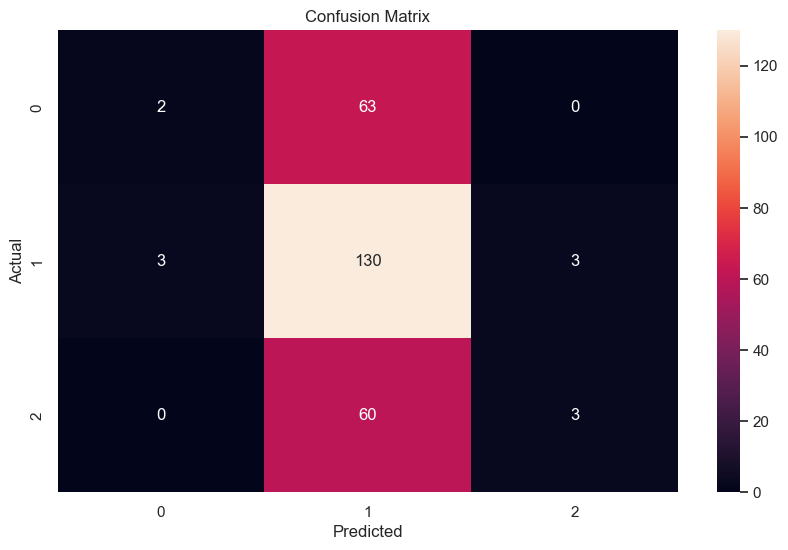

In [73]:
plot_confusion_matrix(test_y_m3, pred_y_m3)

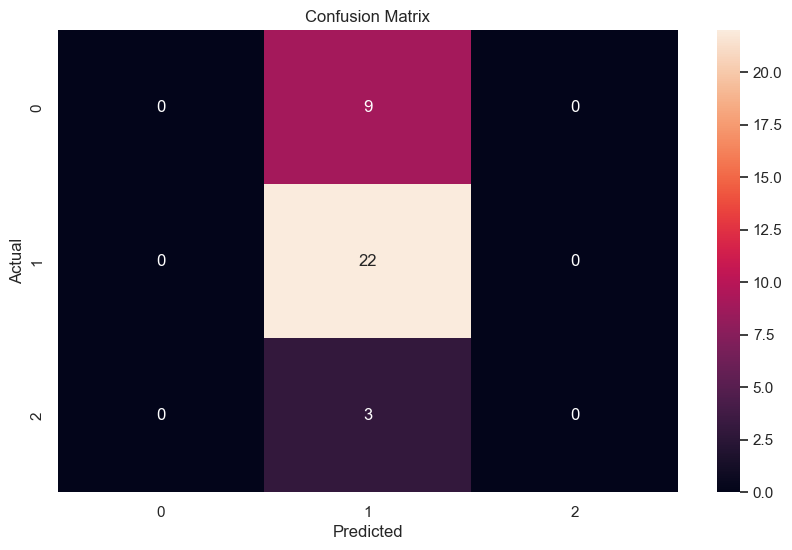

In [230]:
plot_confusion_matrix(test_y_agg_m3, pred_y_agg_m3)

### 3b. Combined models - Concat text embeddings with numerical features (one hot encoding of domains only)

In [234]:
df_labelled_m3b = df_labelled.copy()
df_train_test_m3b = df_labelled_m3b[['text', 'domain_group', 'article_index', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m3b['label'] = df_train_test_m3b['label'].map(label_mapper)

# one-hot encode domain_group
df_train_test_m3b = pd.get_dummies(df_train_test_m3b, columns=['domain_group'])

df_train_test_m3b

C:\Users\edmun\AppData\Local\Temp\ipykernel_24372\4174607364.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m3b['label'] = df_train_test_m3b['label'].map(label_mapper)


,text,article_index,label,domain_group_asiaone,domain_group_businesstimes,domain_group_channelnewsasia,domain_group_goodyfeed,domain_group_mothership,domain_group_mustsharenews,domain_group_ricemedia,domain_group_stomp,domain_group_straitstimes,domain_group_thenewpaper,domain_group_theonlinecitizen,domain_group_today,domain_group_yahoosingapore
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,others,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,â€˜The Godfather of AI' leaves Google and warn...,others,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,â€˜She left an incredible legacy': Tributes po...,4d/toto,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,sea games,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,sea games,1,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",others,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1313,#trending: Primary 3 mathematics question with...,healthcare,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1314,#trending: Former SIA cabin crew offers explan...,others,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1315,#trending: Blackpink fans criticise fellow con...,ndp,2,0,0,0,0,0,0,0,0,0,0,0,1,0


In [236]:
domain_group_cols = list(df_train_test_m3b.columns[3:])
domain_group_cols

['domain_group_asiaone',
 'domain_group_businesstimes',
 'domain_group_channelnewsasia',
 'domain_group_goodyfeed',
 'domain_group_mothership',
 'domain_group_mustsharenews',
 'domain_group_ricemedia',
 'domain_group_stomp',
 'domain_group_straitstimes',
 'domain_group_thenewpaper',
 'domain_group_theonlinecitizen',
 'domain_group_today',
 'domain_group_yahoosingapore']

In [237]:
# Create train, val and test datasets
train_val_df_m3b, test_df_m3b = train_test_split(df_train_test_m3b, test_size=0.2, random_state=42, stratify=df_train_test_m3b['label'])
train_df_m3b, val_df_m3b = train_test_split(train_val_df_m3b, test_size=0.2, random_state=42, stratify=train_val_df_m3b['label'])

In [238]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from torch.optim import Adam

In [239]:
# Define the numeric model
class NumericModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NumericModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the final model
class FinalModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FinalModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.log_softmax(out)
        return out

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['text']  
        numeric = torch.tensor(row[domain_group_cols].apply(pd.to_numeric).values, dtype=torch.float)  
        label = torch.tensor(row['label'], dtype=torch.long) 
        return text, numeric, label


In [240]:

# Function for training
def train(dataloader, sentence_model, numeric_model, final_model, criterion, optimizer):
    final_model.train()
    numeric_model.train()
    sentence_model.train()

    total_loss = 0

    for batch in dataloader:
        # Separate the text, numeric, and label data
        text_data, numeric_data, labels = batch

        # Convert text to embeddings
        text_embeddings = sentence_model.encode(text_data)

        # Pass numeric data through our numeric model
        numeric_embeddings = numeric_model(numeric_data)

        # Concatenate text and numeric embeddings
        combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

        # Pass through the final model
        predictions = final_model(combined_embeddings)

        # Reshape predictions
        predictions = predictions.squeeze()

        # Compute loss
        loss = criterion(predictions, labels.long())
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return total_loss / len(dataloader)

# Function for evaluation
def evaluate(dataloader, sentence_model, numeric_model, final_model, criterion):
    final_model.eval()
    numeric_model.eval()
    sentence_model.eval()
    
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            # Separate the text, numeric, and label data
            text_data, numeric_data, labels = batch

            # Convert text to embeddings
            text_embeddings = sentence_model.encode(text_data)

            # Pass numeric data through our numeric model
            numeric_embeddings = numeric_model(numeric_data)

            # Concatenate text and numeric embeddings
            combined_embeddings = torch.cat((torch.tensor(text_embeddings), numeric_embeddings), dim=1)

            # Pass through the final model
            predictions = final_model(combined_embeddings)

            # Reshape predictions
            predictions = predictions.squeeze()

            # Compute loss
            loss = criterion(predictions, labels.long())
            total_loss += loss.item()

    return total_loss / len(dataloader)


In [241]:
# Create Datasets
train_dataset_m3b = CustomDataset(train_df_m3b)
val_dataset_m3b = CustomDataset(val_df_m3b)
test_dataset_m3b = CustomDataset(test_df_m3b)

# Create DataLoaders
batch_size = 32  
train_dataloader_m3b = DataLoader(train_dataset_m3b, batch_size=batch_size, shuffle=True)
val_dataloader_m3b = DataLoader(val_dataset_m3b, batch_size=batch_size, shuffle=False)
test_dataloader_m3b = DataLoader(test_dataset_m3b, batch_size=batch_size, shuffle=False)

# Instantiate SentenceTransformer
# sentence_model = SentenceTransformer('all-mpnet-base-v2')
sentence_model_m3b = SentenceTransformer('all-MiniLM-L6-v2')

# Instantiate NumericModel
numeric_model_m3b = NumericModel(len(domain_group_cols), 64, 512)  

# Instantiate FinalModel
final_model_m3b = FinalModel(896, 64, 3)

# Define the criterion and the optimizer
criterion_m3b = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
optimizer_m3b = Adam(list(numeric_model_m3b.parameters()) + list(final_model_m3b.parameters()) + list(sentence_model_m3b.parameters()), lr=0.0001)

In [242]:
N_EPOCHS = 100

# Save train and validation losses

train_losses_m3b = []
val_losses_m3b = []

# Train and evaluate the model
for epoch in range(N_EPOCHS):  
    train_loss = train(train_dataloader_m3b, sentence_model_m3b, numeric_model_m3b, final_model_m3b, criterion_m3b, optimizer_m3b)
    valid_loss = evaluate(val_dataloader_m3b, sentence_model_m3b, numeric_model_m3b, final_model_m3b, criterion_m3b)
    train_losses_m3b.append(train_loss)
    val_losses_m3b.append(valid_loss)
    print(f'Epoch {epoch}: Train Loss: {train_loss}, Validation Loss: {valid_loss}')

    # early stopping
    if epoch > 30 and val_losses_m3b[epoch-1] < val_losses_m3b[epoch] and val_losses_m3b[epoch-2] < val_losses_m3b[epoch-1]:
        break

Epoch 0: Train Loss: 1.0898211267259386, Validation Loss: 1.0703580209187098
Epoch 1: Train Loss: 1.049715479214986, Validation Loss: 1.038941400391715
Epoch 2: Train Loss: 1.0309795119144298, Validation Loss: 1.0236023919922965
Epoch 3: Train Loss: 1.0200628969404433, Validation Loss: 1.0179694209780012
Epoch 4: Train Loss: 1.0182022518581815, Validation Loss: 1.0132619142532349
Epoch 5: Train Loss: 1.0046844990165145, Validation Loss: 1.0082876426833016
Epoch 6: Train Loss: 1.0038080789424755, Validation Loss: 1.0027886373656136
Epoch 7: Train Loss: 0.9969681523464344, Validation Loss: 0.9977893573897225
Epoch 8: Train Loss: 0.9874893073682431, Validation Loss: 0.9926514795848301
Epoch 9: Train Loss: 0.9833319165088512, Validation Loss: 0.9885535069874355
Epoch 10: Train Loss: 0.9736531994960926, Validation Loss: 0.9844774348395211
Epoch 11: Train Loss: 0.9740399122238159, Validation Loss: 0.9806884356907436
Epoch 12: Train Loss: 0.9682460184450503, Validation Loss: 0.976821805749620

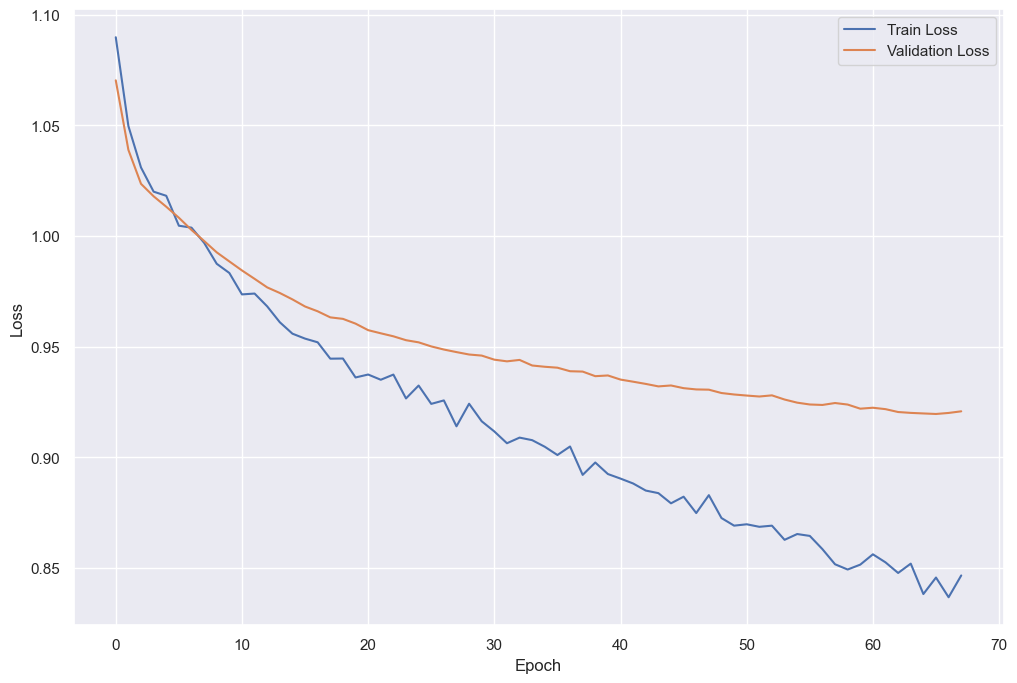

In [247]:
# Plot the train and validation losses using seaborn

plt.figure(figsize=(12, 8))
plt.plot(train_losses_m3b, label='Train Loss')
plt.plot(val_losses_m3b, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [248]:
final_model_m3b.eval()  # Set the model to evaluation mode
sentence_model_m3b.eval()
numeric_model_m3b.eval()

pred_y_m3b = []  # Initialize an empty list to store predictions

with torch.no_grad():  # No need to calculate gradients for evaluation
    for texts, numerics, _ in test_dataloader_m3b:  # We don't care about labels here
        texts = [sentence_model_m3b.encode(text) for text in texts]
        texts = torch.tensor(texts, dtype=torch.float)
        numerics = numeric_model_m3b(numerics)
        inputs = torch.cat((texts, numerics), dim=1)
        log_outputs = final_model_m3b(inputs)
        outputs = torch.exp(log_outputs)  # Convert to probabilities
        _, predicted = torch.max(outputs.data, 1)  # Choose the class with the highest score
        pred_y_m3b.extend(predicted.tolist())  # Convert tensor to list and append to predictions

pred_y_m3b = np.array(pred_y_m3b)  # Convert predictions to NumPy array

In [249]:
# plot confusion matrix

test_y_m3b = test_df_m3b['label'].values

res_m3b = evaluate_predictions(test_y_m3b, pred_y_m3b)
res_m3b

,macro
accuracy,0.511
precision,0.474
recall,0.389
f1,0.375


In [260]:
test_y_agg_m3b, pred_y_agg_m3b = get_predictions_agg(test_df_m3b, pred_y_m3b)
res_agg_m3b = evaluate_predictions(test_y_agg_m3b, pred_y_agg_m3b)
res_agg_m3b

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,macro
accuracy,0.618
precision,0.326
recall,0.414
f1,0.363


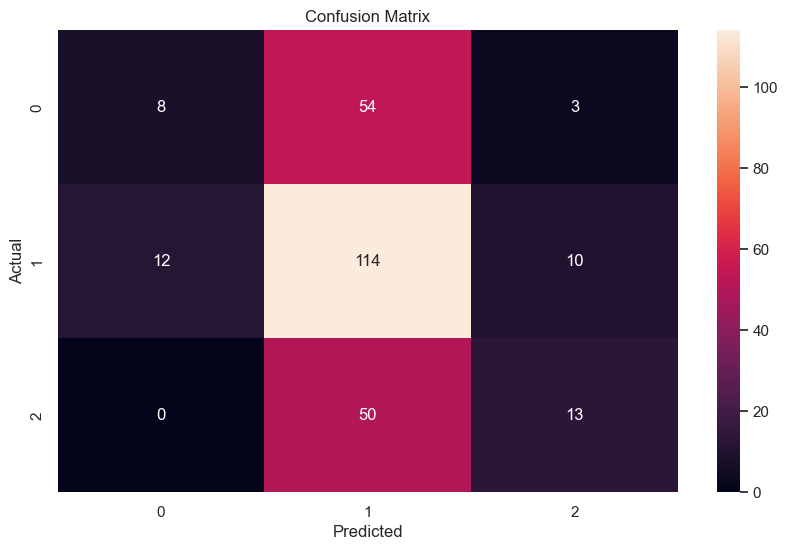

In [251]:
plot_confusion_matrix(test_y_m3b, pred_y_m3b)


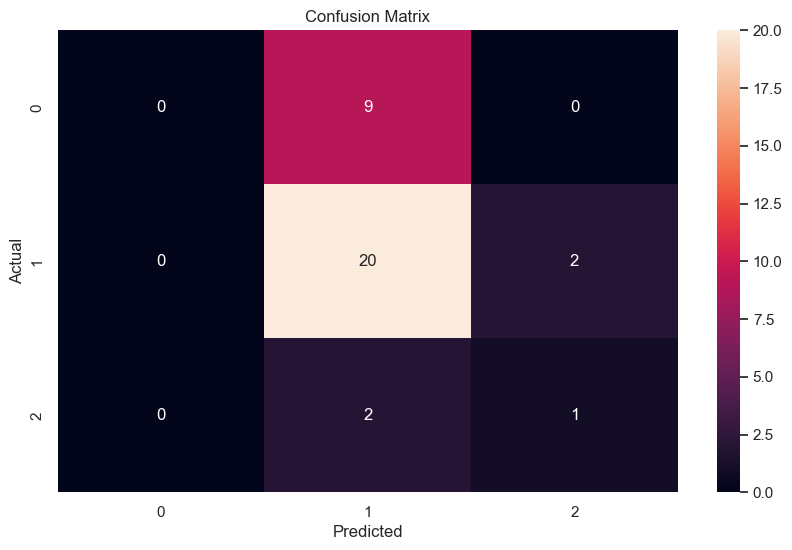

In [252]:
plot_confusion_matrix(test_y_agg_m3b, pred_y_agg_m3b)

### 4. Multimodel Transformers

In [253]:
df_labelled_m4 = df_labelled.copy()
df_train_test_m4 = df_labelled_m4[['text', 'mean_monthly_visits', 'mean_monthly_unique_visitors', 'article_index', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m4['label'] = df_train_test_m4['label'].map(label_mapper)
df_train_test_m4

C:\Users\edmun\AppData\Local\Temp\ipykernel_24372\3254361604.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m4['label'] = df_train_test_m4['label'].map(label_mapper)


,text,mean_monthly_visits,mean_monthly_unique_visitors,article_index,label
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,3660000,1170000,others,1
1,â€˜The Godfather of AI' leaves Google and warn...,12310000,2230000,others,1
2,â€˜She left an incredible legacy': Tributes po...,12310000,2230000,4d/toto,1
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,2010000,823526,sea games,1
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,14760000,2330000,sea games,1
...,...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",3660000,1170000,others,1
1313,#trending: Primary 3 mathematics question with...,3660000,1170000,healthcare,1
1314,#trending: Former SIA cabin crew offers explan...,3660000,1170000,others,0
1315,#trending: Blackpink fans criticise fellow con...,3660000,1170000,ndp,2


In [320]:
# Train test split

train_df_m4, test_df_m4 = train_test_split(df_train_test_m4, test_size=0.2, random_state=42, stratify=df_train_test_m4['label'])

In [324]:
df_train_test_m4.article_index.value_counts().reset_index()

,index,article_index
0,others,644
1,sea games,208
2,food prices,81
3,ndp,52
4,football,40
5,border reopening,39
6,4d/toto,32
7,weather,25
8,deaths,15
9,scams,13


In [313]:
train_df_m4.article_index.value_counts()


others                      517
sea games                   170
food prices                  64
ndp                          47
football                     28
border reopening             28
4d/toto                      27
weather                      19
parliament                   10
mbs                          10
scams                        10
layoffs                       9
winter olympics               9
deaths                        8
service disruptions           7
coe prices                    7
world cup                     6
msia politics                 6
taxi fares                    5
resale prices                 5
teachers                      5
hari raya                     5
chicken supply                5
ndr                           5
safe management measures      5
nsf                           4
local athletes                4
support measures              4
dbs                           3
crypto                        3
g20                           2
hospital

In [314]:
test_df_m4.article_index.value_counts()


others                 127
sea games               38
food prices             17
football                12
border reopening        11
deaths                   7
weather                  6
4d/toto                  5
ndp                      5
world cup                3
scams                    3
nsf                      2
hari raya                2
crypto                   2
parliament               2
support measures         2
earthquake               2
landslide                2
mbs                      1
core inflation           1
lockdown                 1
healthcare               1
health issues            1
chicken supply           1
banks                    1
currency                 1
local athletes           1
teachers                 1
layoffs                  1
petrol prices            1
resale prices            1
service disruptions      1
winter olympics          1
case numbers             1
Name: article_index, dtype: int64

In [255]:
# normalising mean_monthly_visits and mean_monthly_unique_visitors on train_df

from sklearn.preprocessing import MinMaxScaler

scaler_m4 = MinMaxScaler()
train_df_m4[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler_m4.fit_transform(train_df_m4[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
train_df_m4

# normalising mean_monthly_visits and mean_monthly_unique_visitors on test_df

test_df_m4[['mean_monthly_visits', 'mean_monthly_unique_visitors']] = scaler_m4.transform(test_df_m4[['mean_monthly_visits', 'mean_monthly_unique_visitors']])
test_df_m4

,text,mean_monthly_visits,mean_monthly_unique_visitors,article_index,label
1103,At least 3 Mount Everest climbers killed in de...,0.832321,0.955429,mbs,1
1202,"2 fights, 4 red cards & 1 goal from Beckham: I...",0.453160,0.701374,sea games,1
392,"SEA Games 2023: One week's rest after double, ...",0.832321,0.955429,sea games,2
170,"The Big Read: Beyond IRs and new attractions, ...",1.000000,1.000000,border reopening,1
801,How Mister Donut's new employees are trained a...,1.000000,1.000000,others,1
...,...,...,...,...,...
995,Comedian in China hit with S$2.56 million fine...,0.453160,0.701374,others,2
494,Retiree forced to return to work after downloa...,0.076736,0.151862,others,0
822,Guardians of the Galaxy Vol. 3: Pom 'Mantis' K...,0.332704,0.211731,others,1
191,Taiwan Airline Pilot Allows Influencer Into Co...,0.127382,0.328548,others,1


In [256]:
train_df_m4.to_parquet('data/train_df_m4.parquet')
test_df_m4.to_parquet('data/test_df_m4.parquet')

dataset_m4 = load_dataset("parquet", data_files={'train': "data/train_df_m4.parquet", 'test': "data/test_df_m4.parquet"})
train_dataset_m4 = dataset_m4["train"]
test_dataset_m4 = dataset_m4["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 999.83it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-f3f3a2a071218940/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 997.10it/s]


In [257]:
import pandas as pd
from multimodal_transformers.data import load_data
from transformers import AutoTokenizer

data_df = train_df_m4.copy()
text_cols = ['text']
# The label col is expected to contain integers from 0 to N_classes - 1
label_col = 'label' 
numerical_cols = ['mean_monthly_visits', 'mean_monthly_unique_visitors']
label_list = ['diminishing', 'neutral', 'trending'] # what each label class represents

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

torch_dataset = load_data(
    data_df,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

test_df_m4 = test_df_m4.reset_index(drop=True)
test_df_m4

test_dataset_m4 = load_data(
    test_df_m4,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

In [258]:
from multimodal_transformers.model import AutoModelWithTabular, TabularConfig
from transformers import AutoConfig

num_labels = 3
config = AutoConfig.from_pretrained('bert-base-uncased')
tabular_config = TabularConfig(
    num_labels=num_labels,
    numerical_feat_dim=torch_dataset.numerical_feats.shape[1],
    combine_feat_method='weighted_feature_sum_on_transformer_cat_and_numerical_feats',
)
config.tabular_config = tabular_config

model_m4 = AutoModelWithTabular.from_pretrained('bert-base-uncased', config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'tabular_combiner.laye

In [259]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./logs/model_name",
    logging_dir="./logs/runs",
    overwrite_output_dir=True,
    do_train=True,
    per_device_train_batch_size=32,
    num_train_epochs=5,
    # evaluate_during_training=True,
    logging_steps=25,
)

trainer = Trainer(
  model=model_m4,
  args=training_args,
  train_dataset=torch_dataset,
  eval_dataset=test_dataset_m4,
)

trainer.train()

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 15%|█▌        | 25/165 [04:06<23:04,  9.89s/it]

{'loss': 1.0396, 'learning_rate': 4.242424242424243e-05, 'epoch': 0.76}


 30%|███       | 50/165 [08:07<18:25,  9.61s/it]

{'loss': 1.0007, 'learning_rate': 3.484848484848485e-05, 'epoch': 1.52}


 45%|████▌     | 75/165 [12:07<14:22,  9.58s/it]

{'loss': 0.9087, 'learning_rate': 2.7272727272727273e-05, 'epoch': 2.27}


 61%|██████    | 100/165 [16:06<10:17,  9.49s/it]

{'loss': 0.7979, 'learning_rate': 1.9696969696969697e-05, 'epoch': 3.03}


 76%|███████▌  | 125/165 [20:06<06:22,  9.57s/it]

{'loss': 0.6449, 'learning_rate': 1.2121212121212122e-05, 'epoch': 3.79}


 91%|█████████ | 150/165 [24:04<02:23,  9.57s/it]

{'loss': 0.5073, 'learning_rate': 4.5454545454545455e-06, 'epoch': 4.55}


100%|██████████| 165/165 [26:27<00:00,  9.62s/it]

{'train_runtime': 1587.7196, 'train_samples_per_second': 3.316, 'train_steps_per_second': 0.104, 'train_loss': 0.7861692862077193, 'epoch': 5.0}


TrainOutput(global_step=165, training_loss=0.7861692862077193, metrics={'train_runtime': 1587.7196, 'train_samples_per_second': 3.316, 'train_steps_per_second': 0.104, 'train_loss': 0.7861692862077193, 'epoch': 5.0})

In [266]:

pred_y_m4 = trainer.predict(test_dataset_m4)


100%|██████████| 33/33 [00:01<00:00, 21.32it/s]


In [267]:
test_y_m4 = test_df_m4['label']
pred_y_m4 = pred_y_m4.predictions[0].argmax(axis=1)

res_m4 = evaluate_predictions(test_y_m4, pred_y_m4)
res_m4

,macro
accuracy,0.511
precision,0.470
recall,0.436
f1,0.441


In [268]:
test_y_agg_m4, pred_y_agg_m4 = get_predictions_agg(test_df_m4, pred_y_m4)
res_agg_m4 = evaluate_predictions(test_y_agg_m4, pred_y_agg_m4)
res_agg_m4

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,macro
accuracy,0.706
precision,0.437
recall,0.451
f1,0.439


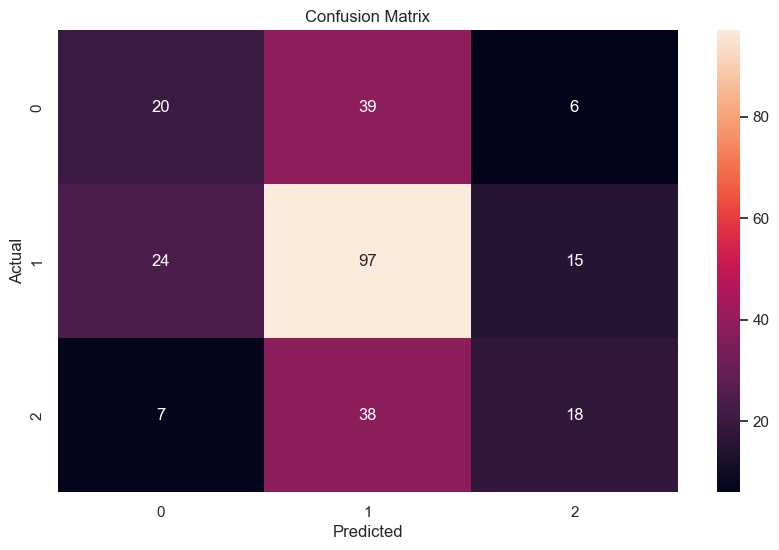

In [269]:
plot_confusion_matrix(test_y_m4, pred_y_m4)


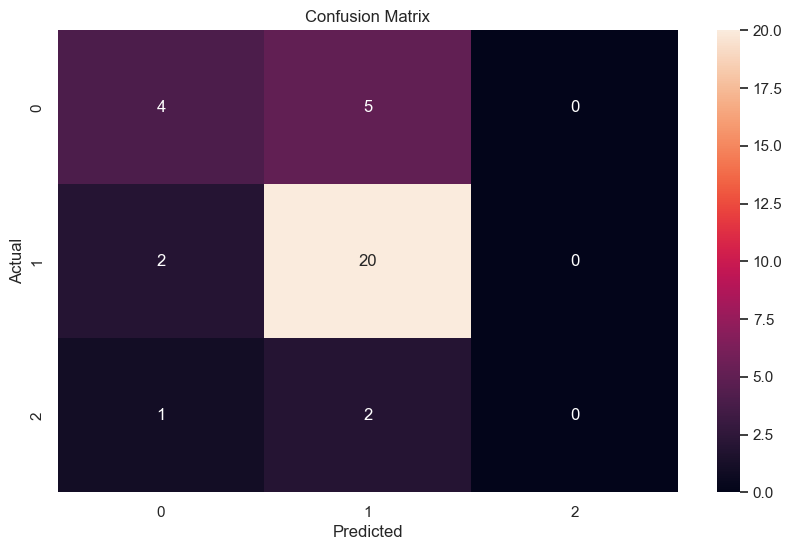

In [270]:
plot_confusion_matrix(test_y_agg_m4, pred_y_agg_m4)


### 4b. Multimodel Transformers with categorical domain encoding

In [272]:
df_labelled_m4b = df_labelled.copy()
df_train_test_m4b = df_labelled_m4b[['text', 'domain_group', 'article_index', 'label']]
label_mapper = {'trending': 2, 'diminishing': 0, 'neutral': 1}
df_train_test_m4b['label'] = df_train_test_m4b['label'].map(label_mapper)

df_train_test_m4b = pd.get_dummies(df_train_test_m4b, columns=['domain_group'])

df_train_test_m4b

C:\Users\edmun\AppData\Local\Temp\ipykernel_24372\2036293521.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_test_m4b['label'] = df_train_test_m4b['label'].map(label_mapper)


,text,article_index,label,domain_group_asiaone,domain_group_businesstimes,domain_group_channelnewsasia,domain_group_goodyfeed,domain_group_mothership,domain_group_mustsharenews,domain_group_ricemedia,domain_group_stomp,domain_group_straitstimes,domain_group_thenewpaper,domain_group_theonlinecitizen,domain_group_today,domain_group_yahoosingapore
0,â€˜The Godfather of AIâ€™ leaves Google and wa...,others,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,â€˜The Godfather of AI' leaves Google and warn...,others,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2,â€˜She left an incredible legacy': Tributes po...,4d/toto,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,â€˜Meltingâ€™ Mixue Mascot In Paya Lebar Has E...,sea games,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,â€˜I was just super pumpedâ€™: Singapore's Sha...,sea games,1,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1312,"#trending: Singaporean artist receives US$10,0...",others,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1313,#trending: Primary 3 mathematics question with...,healthcare,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1314,#trending: Former SIA cabin crew offers explan...,others,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1315,#trending: Blackpink fans criticise fellow con...,ndp,2,0,0,0,0,0,0,0,0,0,0,0,1,0


In [273]:
domain_group_cols = list(df_train_test_m4b.columns[2:])
domain_group_cols

['label',
 'domain_group_asiaone',
 'domain_group_businesstimes',
 'domain_group_channelnewsasia',
 'domain_group_goodyfeed',
 'domain_group_mothership',
 'domain_group_mustsharenews',
 'domain_group_ricemedia',
 'domain_group_stomp',
 'domain_group_straitstimes',
 'domain_group_thenewpaper',
 'domain_group_theonlinecitizen',
 'domain_group_today',
 'domain_group_yahoosingapore']

In [274]:
train_df_m4b, test_df_m4b = train_test_split(df_train_test_m4b, test_size=0.2, random_state=42, stratify=df_train_test_m4b['label'])


In [275]:
train_df_m4b.to_parquet('data/train_df_m4b.parquet')
test_df_m4b.to_parquet('data/test_df_m4b.parquet')

dataset_m4b = load_dataset("parquet", data_files={'train': "data/train_df_m4b.parquet", 'test': "data/test_df_m4b.parquet"})
train_dataset_m4b = dataset_m4b["train"]
test_dataset_m4b = dataset_m4b["test"]

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 1243.13it/s]


Dataset parquet downloaded and prepared to C:/Users/edmun/.cache/huggingface/datasets/parquet/default-9c14694e094b3c13/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


100%|██████████| 2/2 [00:00<00:00, 1000.67it/s]


In [276]:
import pandas as pd
from multimodal_transformers.data import load_data
from transformers import AutoTokenizer

data_df = train_df_m4b.copy()
text_cols = ['text']
# The label col is expected to contain integers from 0 to N_classes - 1
label_col = 'label' 
numerical_cols = domain_group_cols
# categorical_cols = domain_group_cols
label_list = ['diminishing', 'neutral', 'trending'] # what each label class represents

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

torch_dataset_m4b = load_data(
    data_df,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    # categorical_cols=categorical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

test_df_m4b = test_df_m4b.reset_index(drop=True)
test_df_m4b

test_dataset_m4b = load_data(
    test_df_m4b,
    text_cols,
    tokenizer,
    numerical_cols=numerical_cols,
    # categorical_cols=categorical_cols,
    label_col=label_col,
    sep_text_token_str=tokenizer.sep_token
)

In [277]:
from multimodal_transformers.model import AutoModelWithTabular, TabularConfig
from transformers import AutoConfig

num_labels = 3
config = AutoConfig.from_pretrained('bert-base-uncased')
tabular_config = TabularConfig(
    num_labels=num_labels,
    numerical_feat_dim=torch_dataset_m4b.numerical_feats.shape[1],
    # cat_feat_dim=torch_dataset_m4b.cat_feats.shape[1],
    combine_feat_method='weighted_feature_sum_on_transformer_cat_and_numerical_feats',
)
config.tabular_config = tabular_config

model_m4b = AutoModelWithTabular.from_pretrained('bert-base-uncased', config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertWithTabular: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertWithTabular from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertWithTabular from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertWithTabular were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'tabular_combiner.laye

In [278]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./logs/model_name",
    logging_dir="./logs/runs",
    overwrite_output_dir=True,
    do_train=True,
    per_device_train_batch_size=32,
    num_train_epochs=5,
    # evaluate_during_training=True,
    logging_steps=25,
)

trainer_m4b = Trainer(
  model=model_m4b,
  args=training_args,
  train_dataset=torch_dataset_m4b,
  eval_dataset=test_dataset_m4b,
)

trainer_m4b.train()

e:\Dropbox\Internships\GovTech\Codebase\news_matching\venv\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 15%|█▌        | 25/165 [06:18<35:39, 15.29s/it]

{'loss': 1.0341, 'learning_rate': 4.242424242424243e-05, 'epoch': 0.76}


 30%|███       | 50/165 [12:39<29:13, 15.25s/it]

{'loss': 0.9646, 'learning_rate': 3.484848484848485e-05, 'epoch': 1.52}


 45%|████▌     | 75/165 [18:59<22:52, 15.25s/it]

{'loss': 0.8146, 'learning_rate': 2.7272727272727273e-05, 'epoch': 2.27}


 61%|██████    | 100/165 [25:20<16:29, 15.22s/it]

{'loss': 0.6436, 'learning_rate': 1.9696969696969697e-05, 'epoch': 3.03}


 76%|███████▌  | 125/165 [31:46<10:16, 15.42s/it]

{'loss': 0.4759, 'learning_rate': 1.2121212121212122e-05, 'epoch': 3.79}


 91%|█████████ | 150/165 [38:09<03:49, 15.29s/it]

{'loss': 0.3715, 'learning_rate': 4.5454545454545455e-06, 'epoch': 4.55}


100%|██████████| 165/165 [41:57<00:00, 15.26s/it]

{'train_runtime': 2517.6323, 'train_samples_per_second': 2.091, 'train_steps_per_second': 0.066, 'train_loss': 0.6817607157158129, 'epoch': 5.0}


TrainOutput(global_step=165, training_loss=0.6817607157158129, metrics={'train_runtime': 2517.6323, 'train_samples_per_second': 2.091, 'train_steps_per_second': 0.066, 'train_loss': 0.6817607157158129, 'epoch': 5.0})

In [279]:
pred_y_m4b = trainer_m4b.predict(test_dataset_m4b)


  0%|          | 0/33 [00:00<?, ?it/s]

100%|██████████| 33/33 [00:01<00:00, 20.76it/s]


In [280]:
test_y_m4b = test_df_m4b['label']
pred_y_m4b = pred_y_m4b.predictions[0].argmax(axis=1)

res_m4b = evaluate_predictions(test_y_m4b, pred_y_m4b)
res_m4b

,macro
accuracy,0.542
precision,0.507
recall,0.453
f1,0.459


In [284]:
test_y_agg_m4b, pred_y_agg_m4b = get_predictions_agg(test_df_m4b, pred_y_m4b)
res_agg_m4b = evaluate_predictions(test_y_agg_m4b, pred_y_agg_m4b)
res_agg_m4b

,macro
accuracy,0.794
precision,0.714
recall,0.614
f1,0.641


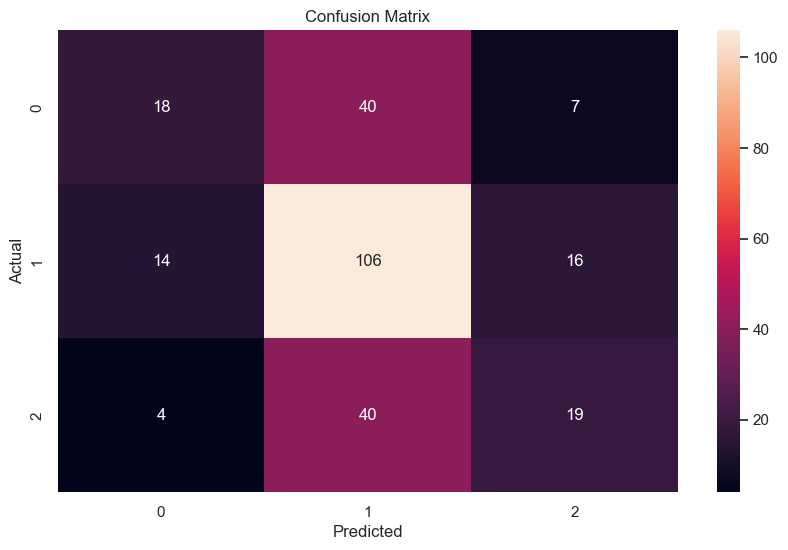

In [285]:
plot_confusion_matrix(test_y_m4b, pred_y_m4b)


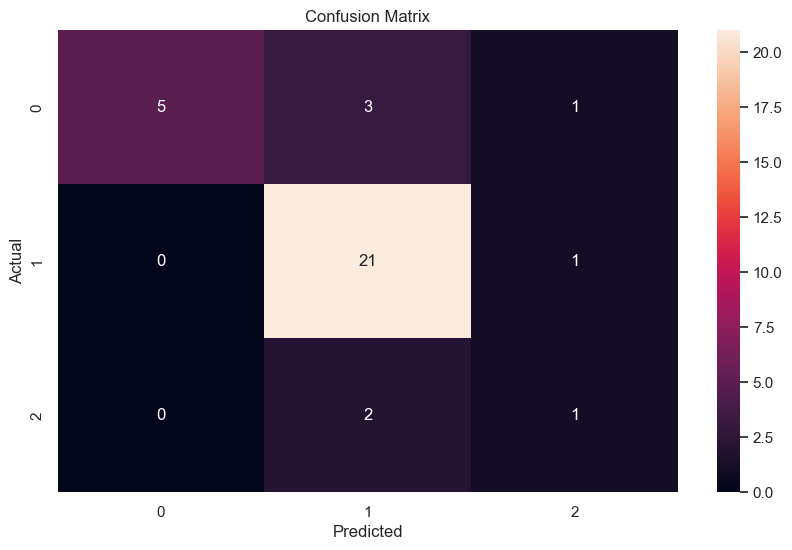

In [286]:
plot_confusion_matrix(test_y_agg_m4b, pred_y_agg_m4b)


### Comaparing Results M1, M2, M2b, M3, M3b, M4, M4b

In [287]:
# combine res_m1, res_m2, res_m3 into a dataframe

res_df = pd.concat([res_m1, res_m2, res_m2b, res_m3, res_m3b, res_m4, res_m4b], axis=1, keys=['SetFit (Text Only)', 'SetFit (Text + numerical)', 'SetFit (Text + binned numerical)', 'Concat (Visitor Count)', 'Concat (One-hot domain)','Multimodal (Visitor Count)','Multimodal (One-hot domain)']).droplevel(1, axis=1).T
res_df

,accuracy,precision,recall,f1
SetFit (Text Only),0.447,0.405,0.378,0.382
SetFit (Text + numerical),0.496,0.459,0.427,0.432
SetFit (Text + binned numerical),0.500,0.470,0.445,0.453
Concat (Visitor Count),0.511,0.471,0.345,0.271
Concat (One-hot domain),0.511,0.474,0.389,0.375
Multimodal (Visitor Count),0.511,0.470,0.436,0.441
Multimodal (One-hot domain),0.542,0.507,0.453,0.459


In [289]:
res_agg_df = pd.concat([res_agg_m1, res_agg_m2, res_agg_m2b, res_agg_m3, res_agg_m3b, res_agg_m4, res_agg_m4b], axis=1, keys=['SetFit (Text Only)', 'SetFit (Text + numerical)', 'SetFit (Text + binned numerical)', 'Concat (Visitor Count)', 'Concat (One-hot domain)','Multimodal (Visitor Count)','Multimodal (One-hot domain)']).droplevel(1, axis=1).T
res_agg_df.sort_values(by='f1', ascending=False)

,accuracy,precision,recall,f1
Multimodal (One-hot domain),0.794,0.714,0.614,0.641
SetFit (Text Only),0.618,0.554,0.554,0.491
SetFit (Text + binned numerical),0.588,0.487,0.465,0.454
Multimodal (Visitor Count),0.706,0.437,0.451,0.439
SetFit (Text + numerical),0.588,0.453,0.421,0.385
Concat (One-hot domain),0.618,0.326,0.414,0.363
Concat (Visitor Count),0.647,0.216,0.333,0.262


In [107]:
# res_df.to_csv('results_100.csv')

In [52]:
res_100 = pd.read_csv('results_100.csv', index_col=0)
res_100["threshold"] = 1.00

res_90 = pd.read_csv('results_090.csv', index_col=0)
res_90["threshold"] = 0.90

res_80 = pd.read_csv('results_080.csv', index_col=0)
res_80["threshold"] = 0.80

# concat all results
res_df_combined = pd.concat([res_100, res_90, res_80], axis=0)
res_df_combined.sort_values(by=['f1'], ascending=False)

,accuracy,precision,recall,f1,threshold
SetFit (Text + numerical),0.504,0.494,0.474,0.477,0.9
SetFit (Text + binned numerical),0.500,0.501,0.463,0.469,0.9
SetFit (Text Only),0.489,0.485,0.459,0.462,0.9
SetFit (Text + binned numerical),0.500,0.470,0.445,0.453,1.0
Concat (One-hot domain),0.500,0.497,0.446,0.437,0.9
SetFit (Text + numerical),0.496,0.459,0.427,0.432,1.0
Multimodal (One-hot domain),0.428,0.428,0.438,0.429,0.8
Multimodal (Visitor Count),0.428,0.428,0.432,0.429,0.8
Multimodal (One-hot domain),0.458,0.429,0.424,0.426,1.0
Concat (Visitor Count),0.420,0.432,0.421,0.424,0.8


In [54]:
res_100.sort_values(by=['f1'], ascending=False)

,accuracy,precision,recall,f1,threshold
SetFit (Text + binned numerical),0.500,0.470,0.445,0.453,1.0
SetFit (Text + numerical),0.496,0.459,0.427,0.432,1.0
Multimodal (One-hot domain),0.458,0.429,0.424,0.426,1.0
Multimodal (Visitor Count),0.485,0.444,0.416,0.419,1.0
SetFit (Text Only),0.447,0.405,0.378,0.382,1.0
Concat (One-hot domain),0.511,0.474,0.389,0.375,1.0
Concat (Visitor Count),0.511,0.471,0.345,0.271,1.0
